# Walk Foward Evaluation

This section mimics a real-life like approach, where a model is trained on a week worth of data, and then used to predict 7 days worth of predictions.

### Module Installation and Importing Libraries

* https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/
* https://vertexai-plaidml.readthedocs-hosted.com/en/latest/installing.html

In [1]:
# scipy
import scipy as sc
print('scipy: %s' % sc.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
# pandas
import pandas as pd
from pandas.plotting import lag_plot
print('pandas: %s' % pd.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.metrics import r2_score
import sklearn as sk
print('sklearn: %s' % sk.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# plaidml keras
import plaidml.keras
plaidml.keras.install_backend()
# keras
import keras as ke
print('keras: %s' % ke.__version__)
# math
import math
import csv
import os.path
import time

scipy: 1.1.0
numpy: 1.15.4
pandas: 0.23.4
statsmodels: 0.9.0
sklearn: 0.20.2
theano: 1.0.3
tensorflow: 1.11.0
keras: 2.2.4


### Configuration Cell

Tweak parametric changes from this cell to influence outcome of experiment. 
NB: This experiment demonstrates at time  step = 1 (1 minute in advance). Further down in experiment, other timestep results are also featured and evaluated.

In [2]:
# Experiment Config
tpcds='TPCDS100' # Schema upon which to operate test
lag=12 # Time Series shift / Lag Step. Each lag value equates to 1 minute. Cannot be less than 1
if lag < 1:
    raise ValueError('Lag value must be greater than 1!')
nrows=None
dtype={'SNAP_ID':int}
test_split=.5 # Denotes which Data Split to operate under when it comes to training / validation
sub_sample_start=350 # Denotes frist 0..n samples (Used for plotting purposes)
y_label = ['CPU_TIME_DELTA', 'IOWAIT_DELTA']# Denotes which label to use for time series experiments

# Feature Selection
parallel_degree = -1
n_estimators=100

# LSTM Network Structure
epochs=300
batch=64
activation='tanh'
initializer='normal'
dropout=0.4
layer=2
state=False

### Read data from file into Pandas Dataframes

In [3]:
# Root path
#root_dir = 'C:/Users/gabriel.sammut/University/Data_ICS5200/Schedule/' + tpcds
root_dir = 'D:/Projects/Datagenerated_ICS5200/Schedule/' + tpcds

# Open Data
rep_hist_snapshot_path = root_dir + '/rep_hist_snapshot.csv'
rep_hist_sysmetric_summary_path = root_dir + '/rep_hist_sysmetric_summary.csv'
rep_hist_sysstat_path = root_dir + '/rep_hist_sysstat.csv'

rep_hist_snapshot_df = pd.read_csv(rep_hist_snapshot_path, 
                                   nrows=nrows,
                                   dtype=dtype,
                                   error_bad_lines=False,
                                   engine='python', 
                                   encoding='utf-8')
rep_hist_sysmetric_summary_df = pd.read_csv(rep_hist_sysmetric_summary_path, nrows=nrows)
rep_hist_sysstat_df = pd.read_csv(rep_hist_sysstat_path, nrows=nrows)

def prettify_header(headers):
    """
    Cleans header list from unwated character strings
    """
    header_list = []
    [header_list.append(header.replace("(","").replace(")","").replace("'","").replace(",","")) for header in headers]
    return header_list

rep_hist_snapshot_df.columns = prettify_header(rep_hist_snapshot_df.columns.values)
rep_hist_sysmetric_summary_df.columns = prettify_header(rep_hist_sysmetric_summary_df.columns.values)
rep_hist_sysstat_df.columns = prettify_header(rep_hist_sysstat_df.columns.values)

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)

Skipping line 1133196: NULL byte detected. This byte cannot be processed in Python's native csv library at the moment, so please pass in engine='c' instead


['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'SQL_ID' 'PLAN_HASH_VALUE'
 'OPTIMIZER_COST' 'OPTIMIZER_MODE' 'OPTIMIZER_ENV_HASH_VALUE'
 'SHARABLE_MEM' 'LOADED_VERSIONS' 'VERSION_COUNT' 'MODULE' 'ACTION'
 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE' 'PARSING_SCHEMA_ID'
 'PARSING_SCHEMA_NAME' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROCESSED_TOTAL' 'ROWS_PROCESSED_DELTA' 'CPU_TIME_TOTAL'
 'CPU_TIME_DELTA' 'ELAPSED_TIME_TOTAL' 'ELAPSED_TIME_DELTA' 'IOWAIT_TOTAL'
 'IOWAIT_DELTA' 'CLWAIT_TOTAL' 'CLWAIT_DELTA' 'APWAIT_TOTAL'
 'APWAIT_DELTA' 'CCWAIT_TOTAL' 'CCWAIT_DELTA' 'DIRECT_WRITES_TOTAL'
 'DIRECT_WRITES_DELTA' 'PLSEXEC_TIME_T

### Pivoting Tables and Changing Matrix Shapes

Changes all dataframe shapes to be similar to each other, where in a number of snap_id timestamps are cojoined with instance metrics.

In [4]:
print('Header Lengths [Before Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# Table REP_HIST_SYSMETRIC_SUMMARY
rep_hist_sysmetric_summary_df = rep_hist_sysmetric_summary_df.pivot_table(index='SNAP_ID', columns='METRIC_NAME', values='AVERAGE')
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df[['SNAP_ID']] = rep_hist_sysmetric_summary_df[['SNAP_ID']].astype(int)
#rep_hist_sysmetric_summary_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysmetric_summary_df.reset_index(inplace=True)
rep_hist_sysmetric_summary_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

# Table REP_HIST_SYSSTAT
rep_hist_sysstat_df = rep_hist_sysstat_df.pivot_table(index='SNAP_ID', columns='STAT_NAME', values='VALUE')
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df[['SNAP_ID']] = rep_hist_sysstat_df[['SNAP_ID']].astype(int)
#rep_hist_sysstat_df = rep_hist_sysstat_df.groupby(['SNAP_ID']).sum()
rep_hist_sysstat_df.reset_index(inplace=True)
rep_hist_sysstat_df.sort_values(by=['SNAP_ID'],inplace=True,ascending=True)

rep_hist_sysmetric_summary_df.rename(str.upper, inplace=True, axis='columns')
rep_hist_sysstat_df.rename(str.upper, inplace=True, axis='columns')

# Group By Values by SNAP_ID , sum all metrics (for table REP_HIST_SNAPSHOT)
rep_hist_snapshot_df = rep_hist_snapshot_df.groupby(['SNAP_ID','DBID','INSTANCE_NUMBER']).sum()
rep_hist_snapshot_df.reset_index(inplace=True)

print('\nHeader Lengths [After Pivot]')
print('REP_HIST_SNAPSHOT: ' + str(len(rep_hist_snapshot_df.columns)))
print('REP_HIST_SYSMETRIC_SUMMARY: ' + str(len(rep_hist_sysmetric_summary_df.columns)))
print('REP_HIST_SYSSTAT: ' + str(len(rep_hist_sysstat_df.columns)))

# DF Shape
print('\nDataframe shapes:\nTable [REP_HIST_SNAPSHOT] - ' + str(rep_hist_snapshot_df.shape))
print('Table [REP_HIST_SYSMETRIC_SUMMARY] - ' + str(rep_hist_sysmetric_summary_df.shape))
print('Table [REP_HIST_SYSSTAT] - ' + str(rep_hist_sysstat_df.shape) + '\n')

print(rep_hist_snapshot_df.columns.values)
print(rep_hist_sysmetric_summary_df.columns.values)
print(rep_hist_sysstat_df.columns.values)
print(rep_hist_snapshot_df.shape)
print(rep_hist_sysmetric_summary_df.shape)
print(rep_hist_sysstat_df.shape)

Header Lengths [Before Pivot]
REP_HIST_SNAPSHOT: 90
REP_HIST_SYSMETRIC_SUMMARY: 26
REP_HIST_SYSSTAT: 16

Header Lengths [After Pivot]
REP_HIST_SNAPSHOT: 78
REP_HIST_SYSMETRIC_SUMMARY: 163
REP_HIST_SYSSTAT: 1180

Dataframe shapes:
Table [REP_HIST_SNAPSHOT] - (12678, 78)
Table [REP_HIST_SYSMETRIC_SUMMARY] - (12678, 163)
Table [REP_HIST_SYSSTAT] - (12678, 1180)

['SNAP_ID' 'DBID' 'INSTANCE_NUMBER' 'PLAN_HASH_VALUE' 'OPTIMIZER_COST'
 'OPTIMIZER_ENV_HASH_VALUE' 'SHARABLE_MEM' 'LOADED_VERSIONS'
 'VERSION_COUNT' 'SQL_PROFILE' 'FORCE_MATCHING_SIGNATURE'
 'PARSING_SCHEMA_ID' 'PARSING_USER_ID' 'FETCHES_TOTAL' 'FETCHES_DELTA'
 'END_OF_FETCH_COUNT_TOTAL' 'END_OF_FETCH_COUNT_DELTA' 'SORTS_TOTAL'
 'SORTS_DELTA' 'EXECUTIONS_TOTAL' 'EXECUTIONS_DELTA'
 'PX_SERVERS_EXECS_TOTAL' 'PX_SERVERS_EXECS_DELTA' 'LOADS_TOTAL'
 'LOADS_DELTA' 'INVALIDATIONS_TOTAL' 'INVALIDATIONS_DELTA'
 'PARSE_CALLS_TOTAL' 'PARSE_CALLS_DELTA' 'DISK_READS_TOTAL'
 'DISK_READS_DELTA' 'BUFFER_GETS_TOTAL' 'BUFFER_GETS_DELTA'
 'ROWS_PROC

### Dealing with Empty Values

In [5]:
def get_na_columns(df, headers):
    """
    Return columns which consist of NAN values
    """
    na_list = []
    for head in headers:
        if df[head].isnull().values.any():
            na_list.append(head)
    return na_list

print('N/A Columns\n')
print('\n REP_HIST_SNAPSHOT Features ' + str(len(rep_hist_snapshot_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_snapshot_df,headers=rep_hist_snapshot_df.columns)) + "\n")
print('REP_HIST_SYSMETRIC_SUMMARY Features ' + str(len(rep_hist_sysmetric_summary_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysmetric_summary_df,headers=rep_hist_sysmetric_summary_df.columns)) + "\n")
print('REP_HIST_SYSSTAT Features ' + str(len(rep_hist_sysstat_df.columns)) + ': ' + str(get_na_columns(df=rep_hist_sysstat_df,headers=rep_hist_sysstat_df.columns)) + "\n")

def fill_na(df):
    """
    Replaces NA columns with 0s
    """
    return df.fillna(0)

# Populating NaN values with amount '0'
rep_hist_snapshot_df.fillna(0, inplace=True)
rep_hist_sysmetric_summary_df.fillna(0, inplace=True)
rep_hist_sysstat_df.fillna(0, inplace=True)

N/A Columns


 REP_HIST_SNAPSHOT Features 78: []

REP_HIST_SYSMETRIC_SUMMARY Features 163: ['ACTIVE PARALLEL SESSIONS', 'ACTIVE SERIAL SESSIONS', 'AVERAGE ACTIVE SESSIONS', 'AVERAGE SYNCHRONOUS SINGLE-BLOCK READ LATENCY', 'BACKGROUND CPU USAGE PER SEC', 'BACKGROUND CHECKPOINTS PER SEC', 'BACKGROUND TIME PER SEC', 'BRANCH NODE SPLITS PER SEC', 'BRANCH NODE SPLITS PER TXN', 'CPU USAGE PER SEC', 'CPU USAGE PER TXN', 'CR BLOCKS CREATED PER SEC', 'CR BLOCKS CREATED PER TXN', 'CR UNDO RECORDS APPLIED PER SEC', 'CR UNDO RECORDS APPLIED PER TXN', 'CAPTURED USER CALLS', 'CELL PHYSICAL IO INTERCONNECT BYTES', 'CONSISTENT READ CHANGES PER SEC', 'CONSISTENT READ CHANGES PER TXN', 'CONSISTENT READ GETS PER SEC', 'CONSISTENT READ GETS PER TXN', 'CURRENT LOGONS COUNT', 'CURRENT OS LOAD', 'CURRENT OPEN CURSORS COUNT', 'CURSOR CACHE HIT RATIO', 'DB BLOCK CHANGES PER SEC', 'DB BLOCK CHANGES PER TXN', 'DB BLOCK CHANGES PER USER CALL', 'DB BLOCK GETS PER SEC', 'DB BLOCK GETS PER TXN', 'DB BLOCK GETS PER U

### Merging Frames

This part merges the following pandas data frame into a single frame:
* REP_HIST_SNAPSHOT
* REP_HIST_SYSMETRIC_SUMMARY
* REP_HIST_SYSSTAT

In [6]:
print
df = pd.merge(rep_hist_snapshot_df, rep_hist_sysmetric_summary_df,how='inner',on ='SNAP_ID')
df = pd.merge(df, rep_hist_sysstat_df,how='inner',on ='SNAP_ID')
print(df.shape)
print('----------------------------------')
print(df.columns.tolist())

(12678, 1419)
----------------------------------
['SNAP_ID', 'DBID', 'INSTANCE_NUMBER', 'PLAN_HASH_VALUE', 'OPTIMIZER_COST', 'OPTIMIZER_ENV_HASH_VALUE', 'SHARABLE_MEM', 'LOADED_VERSIONS', 'VERSION_COUNT', 'SQL_PROFILE', 'FORCE_MATCHING_SIGNATURE', 'PARSING_SCHEMA_ID', 'PARSING_USER_ID', 'FETCHES_TOTAL', 'FETCHES_DELTA', 'END_OF_FETCH_COUNT_TOTAL', 'END_OF_FETCH_COUNT_DELTA', 'SORTS_TOTAL', 'SORTS_DELTA', 'EXECUTIONS_TOTAL', 'EXECUTIONS_DELTA', 'PX_SERVERS_EXECS_TOTAL', 'PX_SERVERS_EXECS_DELTA', 'LOADS_TOTAL', 'LOADS_DELTA', 'INVALIDATIONS_TOTAL', 'INVALIDATIONS_DELTA', 'PARSE_CALLS_TOTAL', 'PARSE_CALLS_DELTA', 'DISK_READS_TOTAL', 'DISK_READS_DELTA', 'BUFFER_GETS_TOTAL', 'BUFFER_GETS_DELTA', 'ROWS_PROCESSED_TOTAL', 'ROWS_PROCESSED_DELTA', 'CPU_TIME_TOTAL', 'CPU_TIME_DELTA', 'ELAPSED_TIME_TOTAL', 'ELAPSED_TIME_DELTA', 'IOWAIT_TOTAL', 'IOWAIT_DELTA', 'CLWAIT_TOTAL', 'CLWAIT_DELTA', 'APWAIT_TOTAL', 'APWAIT_DELTA', 'CCWAIT_TOTAL', 'CCWAIT_DELTA', 'DIRECT_WRITES_TOTAL', 'DIRECT_WRITES_DELTA'

### Data Ordering

Sorting of datasets in order of SNAP_ID.

In [7]:
df.sort_values(by=['SNAP_ID'], ascending=True, inplace=True)
print(df.shape)

(12678, 1419)


### Floating point precision conversion

Each column is converted into a column of type values which are floating point for higher precision.

In [8]:
df.astype('float32', inplace=True)
df = np.round(df, 3) # rounds to 3 dp
print(df.shape)

(12678, 1419)


### Redundant Feature Removal

In this step, redundant features are dropped. Features are considered redundant if exhibit a standard devaition of 0 (meaning no change in value).

In [9]:
def drop_flatline_columns(df):
    columns = df.columns
    flatline_features = []
    for i in range(len(columns)):
        try:
            std = df[columns[i]].std()
            if std == 0:
                flatline_features.append(columns[i])
        except:
            pass
    
    print('\nShape before changes: [' + str(df.shape) + ']')
    df = df.drop(columns=flatline_features)
    print('Shape after changes: [' + str(df.shape) + ']')
    print('Dropped a total [' + str(len(flatline_features)) + ']')
    return df

print('Before column drop:')
print(df.shape)
df = drop_flatline_columns(df=df)
print('\nAfter flatline column drop:')
print(df.shape)
dropped_columns_df = [ 'PLAN_HASH_VALUE',
                       'OPTIMIZER_ENV_HASH_VALUE',
                       'LOADED_VERSIONS',
                       'VERSION_COUNT',
                       'PARSING_SCHEMA_ID',
                       'PARSING_USER_ID',
                       'CON_DBID',
                       'SNAP_LEVEL',
                       'SNAP_FLAG',
                       'COMMAND_TYPE']
df.drop(columns=dropped_columns_df, inplace=True)
print('\nAfter additional column drop:')
print(df.shape)

Before column drop:
(12678, 1419)

Shape before changes: [(12678, 1419)]
Shape after changes: [(12678, 526)]
Dropped a total [893]

After flatline column drop:
(12678, 526)

After additional column drop:
(12678, 516)


### Outlier Detection - Standard Deviation Method

Detection and transformation of outliers, categorized as more than 3 standard deviations away.

If we know that the distribution of values in the sample is Gaussian or Gaussian-like, we can use the standard deviation of the sample as a cut-off for identifying outliers.

The Gaussian distribution has the property that the standard deviation from the mean can be used to reliably summarize the percentage of values in the sample.

For example, within one standard deviation of the mean will cover 68% of the data.

So, if the mean is 50 and the standard deviation is 5, as in the test dataset above, then all data in the sample between 45 and 55 will account for about 68% of the data sample. We can cover more of the data sample if we expand the range as follows:

* 1 Standard Deviation from the Mean: 68%
* 2 Standard Deviations from the Mean: 95%
* 3 Standard Deviations from the Mean: 99.7%

A value that falls outside of 3 standard deviations is part of the distribution, but it is an unlikely or rare event at approximately 1 in 370 samples.

Three standard deviations from the mean is a common cut-off in practice for identifying outliers in a Gaussian or Gaussian-like distribution. For smaller samples of data, perhaps a value of 2 standard deviations (95%) can be used, and for larger samples, perhaps a value of 4 standard deviations (99.9%) can be used.

More infor here: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Outlier detected for column [CPU_TIME_DELTA] at location [0] with value [285533976]
Outlier detected for column [CPU_TIME_DELTA] at location [1] with value [402509154]
Outlier detected for column [CPU_TIME_DELTA] at location [2] with value [1163064072]
Outlier detected for column [CPU_TIME_DELTA] at location [3] with value [387856081]
Outlier detected for column [CPU_TIME_DELTA] at location [138] with value [278050958]
Outlier detected for column [CPU_TIME_DELTA] at location [270] with value [309265406]
Outlier detected for column [CPU_TIME_DELTA] at location [271] with value [270164765]
Outlier detected for column [CPU_TIME_DELTA] at location [281] with value [269807585]
Outlier detected for column [CPU_TIME_DELTA] at location [738] with value [327025257]
Outlier detected for column [CPU_TIME_DELTA] at location [747] with value [1529696755]
Outlier detected for column [CPU_TIME_DELTA] at location [895] with value [271719149]
Outlier detected for column [CPU_TIME_DELTA] at location [89

Outlier detected for column [CPU_TIME_DELTA] at location [5363] with value [303634680]
Outlier detected for column [CPU_TIME_DELTA] at location [5364] with value [309792147]
Outlier detected for column [CPU_TIME_DELTA] at location [5729] with value [347671789]
Outlier detected for column [CPU_TIME_DELTA] at location [5776] with value [342783314]
Outlier detected for column [CPU_TIME_DELTA] at location [5783] with value [291913131]
Outlier detected for column [CPU_TIME_DELTA] at location [6110] with value [557340437]
Outlier detected for column [CPU_TIME_DELTA] at location [6155] with value [416853400]
Outlier detected for column [CPU_TIME_DELTA] at location [6162] with value [271761135]
Outlier detected for column [CPU_TIME_DELTA] at location [6165] with value [485373381]
Outlier detected for column [CPU_TIME_DELTA] at location [6253] with value [341452656]
Outlier detected for column [CPU_TIME_DELTA] at location [6316] with value [403900021]
Outlier detected for column [CPU_TIME_DELTA

Outlier detected for column [CPU_TIME_DELTA] at location [9453] with value [373494639]
Outlier detected for column [CPU_TIME_DELTA] at location [9565] with value [406899459]
Outlier detected for column [CPU_TIME_DELTA] at location [9640] with value [291964116]
Outlier detected for column [CPU_TIME_DELTA] at location [9697] with value [484624959]
Outlier detected for column [CPU_TIME_DELTA] at location [9768] with value [285964181]
Outlier detected for column [CPU_TIME_DELTA] at location [9811] with value [278111230]
Outlier detected for column [CPU_TIME_DELTA] at location [9812] with value [269948736]
Outlier detected for column [CPU_TIME_DELTA] at location [9819] with value [272624336]
Outlier detected for column [CPU_TIME_DELTA] at location [9916] with value [535817123]
Outlier detected for column [CPU_TIME_DELTA] at location [9987] with value [519828517]
Outlier detected for column [CPU_TIME_DELTA] at location [10111] with value [844272411]
Outlier detected for column [CPU_TIME_DELT

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Outlier detected for column [IOWAIT_DELTA] at location [1] with value [3318661592]
Outlier detected for column [IOWAIT_DELTA] at location [2] with value [8621531022]
Outlier detected for column [IOWAIT_DELTA] at location [408] with value [4823320869]
Outlier detected for column [IOWAIT_DELTA] at location [747] with value [9221431666]
Outlier detected for column [IOWAIT_DELTA] at location [1444] with value [3292241621]
Outlier detected for column [IOWAIT_DELTA] at location [1477] with value [3107405505]
Outlier detected for column [IOWAIT_DELTA] at location [1783] with value [4137258354]
Outlier detected for column [IOWAIT_DELTA] at location [1933] with value [3333879155]
Outlier detected for column [IOWAIT_DELTA] at location [2174] with value [4008712288]
Outlier detected for column [IOWAIT_DELTA] at location [2377] with value [8227114392]
Outlier detected for column [IOWAIT_DELTA] at location [2457] with value [3321410966]
Outlier detected for column [IOWAIT_DELTA] at location [2570] 

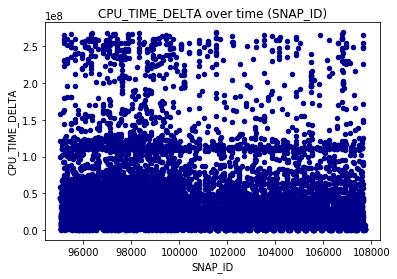

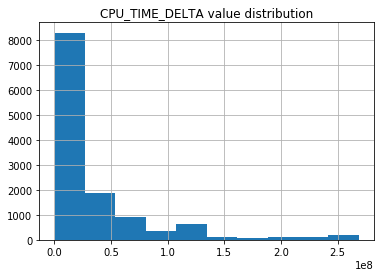

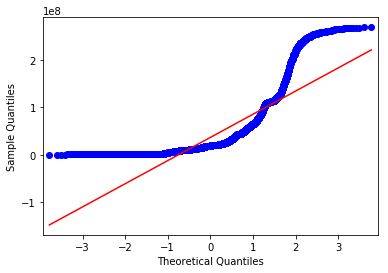

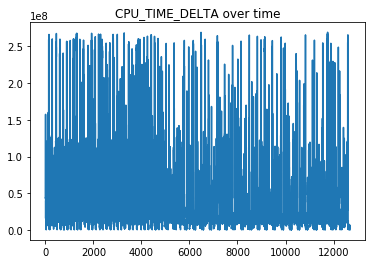

---------------------------------------------------------------


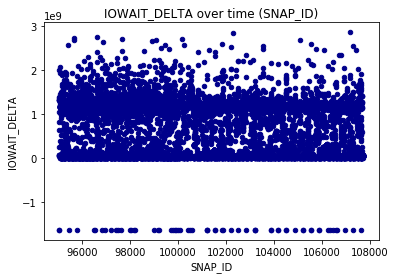

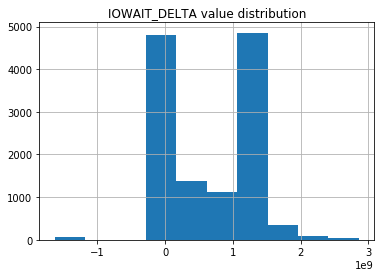

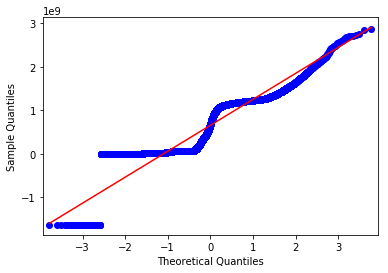

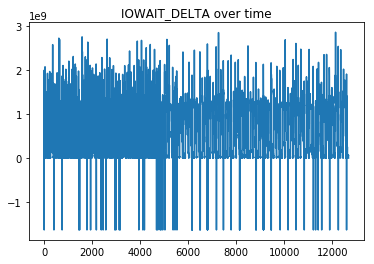

---------------------------------------------------------------


In [10]:
def detect_and_transform_outliers_zscore(df, threshold=3):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        mean = np.mean(df[col])
        std = np.std(df[col])
        
        counter = 0
        for val in df[col]:
            z_score = (val - mean) / std
            if np.abs(z_score) > threshold:
                df[col].iloc[counter] = mean
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

def detect_and_transform_outliers_iqr(df):
    """
    Iterates over input dataframe and transforms outliers (greater then 3 std threshold) into mean value
    
    :param: (Pandas 2D Matrix) Input dataframe
    :param: (Integer) Input standard deviation threshold - 3 equates to the .99% threshold
    """
    for col in df.columns:
        quartile_1, quartile_3 = np.percentile(df.values, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        
        counter = 0
        for val in df[col]:
            if (val > upper_bound) or (val < lower_bound):
                df[col].iloc[counter] = lower_bound
                print('Outlier detected for column [' + col + '] at location [' + str(counter) + '] with value [' + str(val) + ']')
            counter += 1
                
    return df

df[[y_label[0]]] = detect_and_transform_outliers_zscore(df=df[[y_label[0]]])
df[[y_label[1]]] = detect_and_transform_outliers_iqr(df=df[[y_label[1]]])

for label in y_label:
    
    df.plot.scatter(x='SNAP_ID',
                    y=label,
                    c='DarkBlue')
    plt.title(label + " over time (SNAP_ID)")
    plt.show()
    
    df[label].hist(bins=10)
    plt.title(label + ' value distribution')
    plt.show()
    
    qqplot(df[label], line='s')
    plt.show()
    
    df[label].plot.line()
    plt.title(label + ' over time')
    plt.show()
    print('---------------------------------------------------------------')

### Normalization

Relavent Sources:

* http://jmlr.csail.mit.edu/papers/volume3/guyon03a/guyon03a.pdf
* https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a normalization preprocessing technique for data distribution that can closely approximate minimum and maximum observable values per column:

<i>"Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem."</i>

Normalization formula is stated as follows: $$y=(x-min)/(max-min)$$

### Standardization

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/ recommends a standardization preprocessing technique for data distributions that observe a Gaussian spread, with a mean of 0 and a standard deviation of 1 (approximately close to these values):

<i>"Standardization assumes that your observations fit a Gaussian distribution (bell curve) with a well behaved mean and standard deviation. You can still standardize your time series data if this expectation is not met, but you may not get reliable results."</i>

Standardization formula is stated as follows: $$y=(x-mean)/StandardDeviation$$
Mean defined as: $$mean=sum(x)/count(x)$$
Standard Deviation defined as: $$StandardDeviation=sqrt(sum((x-mean)^2)/count(x))$$

In [11]:
# MINMAX SCALER
#df = Normalizer.minmax_scaler(dataframe=df)
train, test = train_test_split(df, test_size=0.5)
trainheaders = train.columns
testheaders = test.columns
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
train = pd.DataFrame(train, columns=trainheaders)
test = pd.DataFrame(test, columns=testheaders)
df = train.append(test, ignore_index=True)

print('\n\n------------------AFTER------------------')
print('------------------df------------------')
print(df.shape)
print('\n\n')
print('\n\ndf')
print(df.head())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)




------------------AFTER------------------
------------------df------------------
(12678, 516)





df
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.248482    4.516997e-09      0.595914                  0.541721   
1  0.272383    1.825464e-07      0.297973                  0.605025   
2  0.756409    6.142506e-09      0.434651                  0.679344   
3  0.815335    1.016901e-08      0.557669                  0.452784   
4  0.600063    4.475118e-09      0.367467                  0.458482   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.354909       0.010663                  0.500099   
1       0.343517       0.019562                  0.329316   
2       0.271664       0.002867                  0.126105   
3       0.169097       0.002446                  0.111503   
4       0.240283       0.007059                  0.308183   

   END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  SORTS_DELTA  \
0                  0.023873     0.421690     

### Split Train Test

Splits dataset into training and validation subsets

In [12]:
y_df = df[y_label]
X_df = df
print("Label " + str(y_label) + " shape: " + str(y_df.shape))
print("Feature matrix shape: " + str(X_df.shape))
print(X_df.head())

Label ['CPU_TIME_DELTA', 'IOWAIT_DELTA'] shape: (12678, 2)
Feature matrix shape: (12678, 516)
    SNAP_ID  OPTIMIZER_COST  SHARABLE_MEM  FORCE_MATCHING_SIGNATURE  \
0  0.248482    4.516997e-09      0.595914                  0.541721   
1  0.272383    1.825464e-07      0.297973                  0.605025   
2  0.756409    6.142506e-09      0.434651                  0.679344   
3  0.815335    1.016901e-08      0.557669                  0.452784   
4  0.600063    4.475118e-09      0.367467                  0.458482   

   FETCHES_TOTAL  FETCHES_DELTA  END_OF_FETCH_COUNT_TOTAL  \
0       0.354909       0.010663                  0.500099   
1       0.343517       0.019562                  0.329316   
2       0.271664       0.002867                  0.126105   
3       0.169097       0.002446                  0.111503   
4       0.240283       0.007059                  0.308183   

   END_OF_FETCH_COUNT_DELTA  SORTS_TOTAL  SORTS_DELTA  \
0                  0.023873     0.421690     0.019401  

### Discrete Training

This section converts the established features from the continuous domain into the discrete domain. Continous values will be converted into discrete, and used to train the model using such values (Utilizes bucket function).

https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/

In [13]:
class BinClass:
    """
    Takes data column, and scales them into discrete buckets. Parameter 'n' denotes number of buckets. This class needs
    to be defined before the LSTM class, since it is referenced during the prediction stage. Since Keras models output a
    continuous output (even when trained on discrete data), the 'BinClass' is required by the LSTM class.
    """
    
    @staticmethod
    def __bucket_val(val, avg):
        """
        Receives threshold value and buckets the val according to the passed threshold
        """
        return np.where(val > avg, 1, 0)

    @staticmethod
    def discretize_value(X, threshold):
        """
        param: X - Input data
        """
        try:
            myfunc_vec = np.vectorize(lambda x: BinClass.__bucket_val(x, threshold))
            return myfunc_vec(X)
        except:
            return BinClass.__bucket_val(X, threshold)

cpu_avg = y_df[y_label[0]].mean()
y_df_cpu = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[0]]].values, cpu_avg), columns=[y_label[0]])
print('CPU y:')
print(np.unique(y_df_cpu.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_cpu == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_cpu == 1)))
#
io_avg = y_df[y_label[1]].mean()
y_df_io = pd.DataFrame(BinClass.discretize_value(y_df[[y_label[1]]].values, io_avg), columns=[y_label[1]])
print('I/O y:')
print(np.unique(y_df_io.values))
print('Number of 0s: ' + str(np.count_nonzero(y_df_io == 0)))
print('Number of 1s: ' + str(np.count_nonzero(y_df_io == 1)))

CPU y:
[0 1]
Number of 0s: 9006
Number of 1s: 3672
I/O y:
[0 1]
Number of 0s: 6312
Number of 1s: 6366


### Time Series Shifting

Shifting the datasets N lag minutes, in order to transform the problem into a supervised dataset. Each Lag Shift equates to 60 seconds (due to the way design of the data capturing tool). For each denoted lag amount, the same number of feature vectors will be stripped away at the beginning.

Features and Labels are separated into seperate dataframes at this point.

https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    n_out += 1
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Frame as supervised learning set
X_df = series_to_supervised(X_df, lag, 0)
y_df = series_to_supervised(y_df, 0, lag)

print('\n-------------\nFeatures')
print(X_df.columns)
print(X_df.shape)
print('\n-------------\nLabels')
print(y_df.columns)
print(y_df.shape)


-------------
Features
Index(['var1(t-12)', 'var2(t-12)', 'var3(t-12)', 'var4(t-12)', 'var5(t-12)',
       'var6(t-12)', 'var7(t-12)', 'var8(t-12)', 'var9(t-12)', 'var10(t-12)',
       ...
       'var507(t)', 'var508(t)', 'var509(t)', 'var510(t)', 'var511(t)',
       'var512(t)', 'var513(t)', 'var514(t)', 'var515(t)', 'var516(t)'],
      dtype='object', length=6708)
(12666, 6708)

-------------
Labels
Index(['var1(t)', 'var2(t)', 'var1(t+1)', 'var2(t+1)', 'var1(t+2)',
       'var2(t+2)', 'var1(t+3)', 'var2(t+3)', 'var1(t+4)', 'var2(t+4)',
       'var1(t+5)', 'var2(t+5)', 'var1(t+6)', 'var2(t+6)', 'var1(t+7)',
       'var2(t+7)', 'var1(t+8)', 'var2(t+8)', 'var1(t+9)', 'var2(t+9)',
       'var1(t+10)', 'var2(t+10)', 'var1(t+11)', 'var2(t+11)', 'var1(t+12)',
       'var2(t+12)'],
      dtype='object')
(12666, 26)


### Feature Selection

Implements a recursive solution, where in features are eliminated based on an ensemble evaluator.

In [15]:
class FeatureEliminator:
    """
    This class is dedicated to housing logic pertaining to feature selection - retaining only labels which are considered
    important.
    """
    def __init__(self, X_df, y_df):
        """
        Class constructor.
        :param X_df: (Pandas) Pandas feature matrix.
        :param y_df: (Pandas) Pandas label matrix.
        :return: None
        """
        self.__X_df = X_df
        self.__y_df = y_df
    
    def rfe_selector(self, test_split=.4, optimum_feature_count=0, parallel_degree=1, max_depth=None, max_features='sqrt', n_estimators=100):
        """
        Recursive Feature Elimination Function. Isolates and eliminated features one by one, up till the desired amount, starting
        by features which are considered less important.
        :param test_split:            (Float) Denotes training/testing data split.
        :param optimum_feature_count: (Integer) Denotes the best estimated number of features to retain before a performance drop
                                                is estimated.
        :param parallel_degree:       (Integer) Denotes model training parallel degree.
        :param max_depth:             (Integer) Denotes number of leaves to evaluate during decision tree pruning.
        :param max_features:          (Integer) Denotes number of features to consider during random subselection.
        :param n_estimators:          (Integer) Number of estimators (trees) to build for decision making.
        :return: (List) This list is composed of boolean values, which correspond to the input feature column headers. True List 
                        values denote columns which have been retained. False values denote eliminated feature headers.
        :return: (List) This list denotes feature rankings, which correspond to the input feature column headers. Values of '1',
                        denote that features have been retained.
        """
        X_df = self.__X_df.values
        y_df = self.__y_df[self.__y_df.columns[0]].values  # We can only use a single target column since RandomForests do not support multi target labels
        print(X_df.shape)
        print(y_df.shape)
        optimum_feature_count = int(optimum_feature_count)
        
        X_train, X_test, y_train, y_test = train_test_split(X_df, 
                                                            y_df, 
                                                            test_size=test_split)
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      n_jobs=parallel_degree,
                                      max_depth=max_depth,
                                      max_features='sqrt')

        # create the RFE model and select N attributes
        rfe_model = RFE(model, optimum_feature_count, step=1)
        rfe_model = rfe_model.fit(X_train, y_train)

        # summarize the selection of the attributes
        print(rfe_model.support_)
        print(rfe_model.ranking_)

        # evaluate the model on testing set
        pred_y = rfe_model.predict(X_test)
        predictions = [round(value) for value in pred_y]
        r2s = r2_score(y_test, predictions)
        
        return rfe_model.support_, rfe_model.ranking_
    
    def get_selected_features(self, column_mask):
        """
        Retrieves features which have not been eliminated from the RFE function.
        :param column_mask: (List) This list is composed of boolean values, which correspond to the input feature column headers. 
                                   True list values denote columns which have been retained. False values denote eliminated 
                                   feature headers. 
        :return: (Pandas) Pandas data matrix.
        """
        recommended_columns = []
        for i in range(len(self.__X_df.columns)):
            if (column_mask[i]):
                recommended_columns.append(self.__X_df.columns[i])
                
        return self.__X_df[recommended_columns]
    
# fe = FeatureEliminator(X_df=X_df,
#                        y_df=y_df)
# column_mask, column_rankings = fe.rfe_selector(test_split=test_split,
#                                                optimum_feature_count=int(X_df.shape[1]/8),
#                                                parallel_degree=2,
#                                                max_depth=1,
#                                                max_features='sqrt',
#                                                n_estimators=n_estimators)
# print(X_df.columns)
# X_df = fe.get_selected_features(column_mask=column_mask)
# print(X_df.columns)
recursively_eliminated_columns = ['var501(t-5)', 'var502(t-5)', 'var504(t-5)', 'var507(t-5)', 'var509(t-5)', 'var511(t-5)', 'var513(t-5)', 'var514(t-5)', 'var515(t-5)', 'var516(t-5)', 'var1(t-4)', 'var3(t-4)', 'var4(t-4)', 'var6(t-4)', 'var7(t-4)', 'var8(t-4)', 'var12(t-4)', 'var13(t-4)', 'var14(t-4)', 'var15(t-4)', 'var16(t-4)', 'var17(t-4)', 'var18(t-4)', 'var19(t-4)', 'var20(t-4)', 'var22(t-4)', 'var23(t-4)', 'var24(t-4)', 'var34(t-4)', 'var36(t-4)', 'var39(t-4)', 'var40(t-4)', 'var41(t-4)', 'var42(t-4)', 'var47(t-4)', 'var48(t-4)', 'var49(t-4)', 'var50(t-4)', 'var51(t-4)', 'var52(t-4)', 'var53(t-4)', 'var54(t-4)', 'var55(t-4)', 'var62(t-4)', 'var63(t-4)', 'var64(t-4)', 'var66(t-4)', 'var67(t-4)', 'var69(t-4)', 'var70(t-4)', 'var71(t-4)', 'var74(t-4)', 'var76(t-4)', 'var77(t-4)', 'var78(t-4)', 'var79(t-4)', 'var80(t-4)', 'var81(t-4)', 'var85(t-4)', 'var86(t-4)', 'var90(t-4)', 'var91(t-4)', 'var92(t-4)', 'var93(t-4)', 'var102(t-4)', 'var104(t-4)', 'var105(t-4)', 'var112(t-4)', 'var113(t-4)', 'var114(t-4)', 'var115(t-4)', 'var117(t-4)', 'var118(t-4)', 'var120(t-4)', 'var121(t-4)', 'var122(t-4)', 'var123(t-4)', 'var124(t-4)', 'var125(t-4)', 'var126(t-4)', 'var127(t-4)', 'var128(t-4)', 'var129(t-4)', 'var130(t-4)', 'var131(t-4)', 'var132(t-4)', 'var133(t-4)', 'var134(t-4)', 'var135(t-4)', 'var136(t-4)', 'var138(t-4)', 'var139(t-4)', 'var140(t-4)', 'var141(t-4)', 'var142(t-4)', 'var143(t-4)', 'var144(t-4)', 'var145(t-4)', 'var146(t-4)', 'var147(t-4)', 'var148(t-4)', 'var149(t-4)', 'var150(t-4)', 'var151(t-4)', 'var152(t-4)', 'var153(t-4)', 'var155(t-4)', 'var156(t-4)', 'var157(t-4)', 'var158(t-4)', 'var159(t-4)', 'var160(t-4)', 'var161(t-4)', 'var162(t-4)', 'var163(t-4)', 'var164(t-4)', 'var165(t-4)', 'var166(t-4)', 'var167(t-4)', 'var168(t-4)', 'var169(t-4)', 'var170(t-4)', 'var171(t-4)', 'var172(t-4)', 'var173(t-4)', 'var174(t-4)', 'var175(t-4)', 'var176(t-4)', 'var177(t-4)', 'var178(t-4)', 'var179(t-4)', 'var180(t-4)', 'var181(t-4)', 'var182(t-4)', 'var183(t-4)', 'var184(t-4)', 'var185(t-4)', 'var186(t-4)', 'var187(t-4)', 'var188(t-4)', 'var189(t-4)', 'var190(t-4)', 'var191(t-4)', 'var192(t-4)', 'var193(t-4)', 'var194(t-4)', 'var195(t-4)', 'var196(t-4)', 'var197(t-4)', 'var198(t-4)', 'var199(t-4)', 'var200(t-4)', 'var201(t-4)', 'var202(t-4)', 'var203(t-4)', 'var204(t-4)', 'var205(t-4)', 'var206(t-4)', 'var207(t-4)', 'var208(t-4)', 'var209(t-4)', 'var210(t-4)', 'var211(t-4)', 'var212(t-4)', 'var213(t-4)', 'var214(t-4)', 'var215(t-4)', 'var220(t-4)', 'var221(t-4)', 'var222(t-4)', 'var224(t-4)', 'var225(t-4)', 'var226(t-4)', 'var227(t-4)', 'var228(t-4)', 'var229(t-4)', 'var230(t-4)', 'var231(t-4)', 'var232(t-4)', 'var233(t-4)', 'var236(t-4)', 'var237(t-4)', 'var239(t-4)', 'var240(t-4)', 'var241(t-4)', 'var244(t-4)', 'var247(t-4)', 'var248(t-4)', 'var249(t-4)', 'var250(t-4)', 'var252(t-4)', 'var254(t-4)', 'var255(t-4)', 'var256(t-4)', 'var257(t-4)', 'var258(t-4)', 'var259(t-4)', 'var260(t-4)', 'var261(t-4)', 'var264(t-4)', 'var265(t-4)', 'var266(t-4)', 'var267(t-4)', 'var268(t-4)', 'var270(t-4)', 'var271(t-4)', 'var273(t-4)', 'var274(t-4)', 'var275(t-4)', 'var276(t-4)', 'var277(t-4)', 'var278(t-4)', 'var287(t-4)', 'var289(t-4)', 'var291(t-4)', 'var292(t-4)', 'var294(t-4)', 'var297(t-4)', 'var298(t-4)', 'var299(t-4)', 'var301(t-4)', 'var302(t-4)', 'var303(t-4)', 'var304(t-4)', 'var305(t-4)', 'var306(t-4)', 'var311(t-4)', 'var312(t-4)', 'var313(t-4)', 'var316(t-4)', 'var317(t-4)', 'var318(t-4)', 'var321(t-4)', 'var322(t-4)', 'var323(t-4)', 'var324(t-4)', 'var326(t-4)', 'var327(t-4)', 'var328(t-4)', 'var331(t-4)', 'var332(t-4)', 'var333(t-4)', 'var335(t-4)', 'var336(t-4)', 'var337(t-4)', 'var338(t-4)', 'var339(t-4)', 'var341(t-4)', 'var344(t-4)', 'var348(t-4)', 'var349(t-4)', 'var355(t-4)', 'var358(t-4)', 'var359(t-4)', 'var362(t-4)', 'var363(t-4)', 'var365(t-4)', 'var366(t-4)', 'var368(t-4)', 'var369(t-4)', 'var376(t-4)', 'var377(t-4)', 'var378(t-4)', 'var379(t-4)', 'var381(t-4)', 'var382(t-4)', 'var383(t-4)', 'var384(t-4)', 'var385(t-4)', 'var386(t-4)', 'var388(t-4)', 'var389(t-4)', 'var390(t-4)', 'var393(t-4)', 'var395(t-4)', 'var397(t-4)', 'var400(t-4)', 'var401(t-4)', 'var403(t-4)', 'var404(t-4)', 'var405(t-4)', 'var407(t-4)', 'var408(t-4)', 'var409(t-4)', 'var410(t-4)', 'var411(t-4)', 'var412(t-4)', 'var413(t-4)', 'var414(t-4)', 'var415(t-4)', 'var416(t-4)', 'var417(t-4)', 'var418(t-4)', 'var419(t-4)', 'var420(t-4)', 'var421(t-4)', 'var422(t-4)', 'var423(t-4)', 'var424(t-4)', 'var425(t-4)', 'var426(t-4)', 'var427(t-4)', 'var428(t-4)', 'var429(t-4)', 'var430(t-4)', 'var431(t-4)', 'var432(t-4)', 'var433(t-4)', 'var434(t-4)', 'var435(t-4)', 'var436(t-4)', 'var437(t-4)', 'var438(t-4)', 'var439(t-4)', 'var440(t-4)', 'var441(t-4)', 'var442(t-4)', 'var443(t-4)', 'var444(t-4)', 'var445(t-4)', 'var446(t-4)', 'var447(t-4)', 'var448(t-4)', 'var449(t-4)', 'var450(t-4)', 'var451(t-4)', 'var452(t-4)', 'var453(t-4)', 'var454(t-4)', 'var455(t-4)', 'var456(t-4)', 'var457(t-4)', 'var458(t-4)', 'var459(t-4)', 'var460(t-4)', 'var461(t-4)', 'var462(t-4)', 'var463(t-4)', 'var464(t-4)', 'var465(t-4)', 'var466(t-4)', 'var467(t-4)', 'var468(t-4)', 'var469(t-4)', 'var470(t-4)', 'var471(t-4)', 'var472(t-4)', 'var473(t-4)', 'var474(t-4)', 'var475(t-4)', 'var476(t-4)', 'var477(t-4)', 'var478(t-4)', 'var479(t-4)', 'var480(t-4)', 'var481(t-4)', 'var482(t-4)', 'var483(t-4)', 'var484(t-4)', 'var485(t-4)', 'var486(t-4)', 'var487(t-4)', 'var488(t-4)', 'var489(t-4)', 'var490(t-4)', 'var491(t-4)', 'var492(t-4)', 'var493(t-4)', 'var494(t-4)', 'var495(t-4)', 'var496(t-4)', 'var497(t-4)', 'var498(t-4)', 'var499(t-4)', 'var500(t-4)', 'var501(t-4)', 'var502(t-4)', 'var503(t-4)', 'var504(t-4)', 'var505(t-4)', 'var510(t-4)', 'var511(t-4)', 'var513(t-4)', 'var514(t-4)', 'var1(t-3)', 'var2(t-3)', 'var5(t-3)', 'var6(t-3)', 'var7(t-3)', 'var8(t-3)', 'var10(t-3)', 'var11(t-3)', 'var14(t-3)', 'var15(t-3)', 'var17(t-3)', 'var18(t-3)', 'var25(t-3)', 'var26(t-3)', 'var28(t-3)', 'var29(t-3)', 'var30(t-3)', 'var31(t-3)', 'var32(t-3)', 'var33(t-3)', 'var34(t-3)', 'var35(t-3)', 'var41(t-3)', 'var42(t-3)', 'var44(t-3)', 'var47(t-3)', 'var50(t-3)', 'var51(t-3)', 'var53(t-3)', 'var57(t-3)', 'var62(t-3)', 'var67(t-3)', 'var68(t-3)', 'var71(t-3)', 'var77(t-3)', 'var78(t-3)', 'var79(t-3)', 'var80(t-3)', 'var81(t-3)', 'var82(t-3)', 'var83(t-3)', 'var84(t-3)', 'var85(t-3)', 'var86(t-3)', 'var89(t-3)', 'var96(t-3)', 'var97(t-3)', 'var98(t-3)', 'var101(t-3)', 'var109(t-3)', 'var110(t-3)', 'var113(t-3)', 'var115(t-3)', 'var116(t-3)', 'var117(t-3)', 'var118(t-3)', 'var125(t-3)', 'var126(t-3)', 'var127(t-3)', 'var130(t-3)', 'var131(t-3)', 'var133(t-3)', 'var134(t-3)', 'var137(t-3)', 'var139(t-3)', 'var140(t-3)', 'var142(t-3)', 'var143(t-3)', 'var144(t-3)', 'var145(t-3)', 'var146(t-3)', 'var147(t-3)', 'var149(t-3)', 'var156(t-3)', 'var157(t-3)', 'var158(t-3)', 'var159(t-3)', 'var160(t-3)', 'var161(t-3)', 'var167(t-3)', 'var168(t-3)', 'var169(t-3)', 'var170(t-3)', 'var171(t-3)', 'var172(t-3)', 'var173(t-3)', 'var175(t-3)', 'var177(t-3)', 'var179(t-3)', 'var181(t-3)', 'var182(t-3)', 'var184(t-3)', 'var187(t-3)', 'var192(t-3)', 'var194(t-3)', 'var196(t-3)', 'var197(t-3)', 'var198(t-3)', 'var199(t-3)', 'var200(t-3)', 'var202(t-3)', 'var203(t-3)', 'var204(t-3)', 'var205(t-3)', 'var206(t-3)', 'var207(t-3)', 'var208(t-3)', 'var209(t-3)', 'var210(t-3)', 'var211(t-3)', 'var212(t-3)', 'var214(t-3)', 'var215(t-3)', 'var216(t-3)', 'var217(t-3)', 'var218(t-3)', 'var219(t-3)', 'var220(t-3)', 'var221(t-3)', 'var222(t-3)', 'var223(t-3)', 'var224(t-3)', 'var225(t-3)', 'var226(t-3)', 'var227(t-3)', 'var228(t-3)', 'var229(t-3)', 'var230(t-3)', 'var231(t-3)', 'var232(t-3)', 'var234(t-3)', 'var235(t-3)', 'var236(t-3)', 'var237(t-3)', 'var238(t-3)', 'var239(t-3)', 'var240(t-3)', 'var241(t-3)', 'var242(t-3)', 'var243(t-3)', 'var244(t-3)', 'var245(t-3)', 'var246(t-3)', 'var247(t-3)', 'var248(t-3)', 'var249(t-3)', 'var250(t-3)', 'var251(t-3)', 'var252(t-3)', 'var253(t-3)', 'var254(t-3)', 'var255(t-3)', 'var256(t-3)', 'var257(t-3)', 'var258(t-3)', 'var259(t-3)', 'var260(t-3)', 'var261(t-3)', 'var262(t-3)', 'var263(t-3)', 'var264(t-3)', 'var266(t-3)', 'var267(t-3)', 'var268(t-3)', 'var269(t-3)', 'var270(t-3)', 'var271(t-3)', 'var272(t-3)', 'var273(t-3)', 'var274(t-3)', 'var275(t-3)', 'var277(t-3)', 'var278(t-3)', 'var279(t-3)', 'var280(t-3)', 'var281(t-3)', 'var282(t-3)', 'var283(t-3)', 'var284(t-3)', 'var285(t-3)', 'var286(t-3)', 'var287(t-3)', 'var288(t-3)', 'var289(t-3)', 'var290(t-3)', 'var292(t-3)', 'var293(t-3)', 'var294(t-3)', 'var300(t-3)', 'var301(t-3)', 'var306(t-3)', 'var309(t-3)', 'var310(t-3)', 'var311(t-3)', 'var312(t-3)', 'var313(t-3)', 'var315(t-3)', 'var317(t-3)', 'var318(t-3)', 'var319(t-3)', 'var320(t-3)', 'var321(t-3)', 'var322(t-3)', 'var323(t-3)', 'var326(t-3)', 'var335(t-3)', 'var336(t-3)', 'var337(t-3)', 'var338(t-3)', 'var339(t-3)', 'var340(t-3)', 'var342(t-3)', 'var343(t-3)', 'var346(t-3)', 'var347(t-3)', 'var349(t-3)', 'var352(t-3)', 'var353(t-3)', 'var355(t-3)', 'var357(t-3)', 'var359(t-3)', 'var364(t-3)', 'var365(t-3)', 'var366(t-3)', 'var367(t-3)', 'var374(t-3)', 'var376(t-3)', 'var377(t-3)', 'var378(t-3)', 'var379(t-3)', 'var382(t-3)', 'var383(t-3)', 'var384(t-3)', 'var385(t-3)', 'var386(t-3)', 'var387(t-3)', 'var389(t-3)', 'var391(t-3)', 'var397(t-3)', 'var398(t-3)', 'var399(t-3)', 'var401(t-3)', 'var402(t-3)', 'var418(t-3)', 'var419(t-3)', 'var421(t-3)', 'var423(t-3)', 'var424(t-3)', 'var425(t-3)', 'var427(t-3)', 'var428(t-3)', 'var429(t-3)', 'var430(t-3)', 'var432(t-3)', 'var436(t-3)', 'var437(t-3)', 'var438(t-3)', 'var439(t-3)', 'var441(t-3)', 'var444(t-3)', 'var445(t-3)', 'var446(t-3)', 'var447(t-3)', 'var450(t-3)', 'var451(t-3)', 'var452(t-3)', 'var454(t-3)', 'var455(t-3)', 'var456(t-3)', 'var457(t-3)', 'var458(t-3)', 'var462(t-3)', 'var463(t-3)', 'var464(t-3)', 'var469(t-3)', 'var471(t-3)', 'var472(t-3)', 'var474(t-3)', 'var475(t-3)', 'var476(t-3)', 'var478(t-3)', 'var481(t-3)', 'var484(t-3)', 'var485(t-3)', 'var489(t-3)', 'var490(t-3)', 'var491(t-3)', 'var492(t-3)', 'var494(t-3)', 'var496(t-3)', 'var497(t-3)', 'var498(t-3)', 'var499(t-3)', 'var500(t-3)', 'var501(t-3)', 'var502(t-3)', 'var503(t-3)', 'var504(t-3)', 'var505(t-3)', 'var506(t-3)', 'var507(t-3)', 'var508(t-3)', 'var509(t-3)', 'var510(t-3)', 'var511(t-3)', 'var512(t-3)', 'var513(t-3)', 'var514(t-3)', 'var515(t-3)', 'var516(t-3)', 'var1(t-2)', 'var2(t-2)', 'var3(t-2)', 'var4(t-2)', 'var5(t-2)', 'var6(t-2)', 'var7(t-2)', 'var9(t-2)', 'var10(t-2)', 'var11(t-2)', 'var12(t-2)', 'var13(t-2)', 'var15(t-2)', 'var16(t-2)', 'var17(t-2)', 'var18(t-2)', 'var19(t-2)', 'var21(t-2)', 'var22(t-2)', 'var23(t-2)', 'var24(t-2)', 'var26(t-2)', 'var27(t-2)', 'var29(t-2)', 'var30(t-2)', 'var31(t-2)', 'var32(t-2)', 'var33(t-2)', 'var35(t-2)', 'var36(t-2)', 'var37(t-2)', 'var39(t-2)', 'var40(t-2)', 'var41(t-2)', 'var42(t-2)', 'var44(t-2)', 'var45(t-2)', 'var46(t-2)', 'var48(t-2)', 'var49(t-2)', 'var50(t-2)', 'var51(t-2)', 'var53(t-2)', 'var54(t-2)', 'var74(t-2)', 'var75(t-2)', 'var77(t-2)', 'var79(t-2)', 'var80(t-2)', 'var81(t-2)', 'var83(t-2)', 'var84(t-2)', 'var85(t-2)', 'var86(t-2)', 'var99(t-2)', 'var100(t-2)', 'var101(t-2)', 'var102(t-2)', 'var105(t-2)', 'var155(t-2)', 'var158(t-2)', 'var159(t-2)', 'var168(t-2)', 'var169(t-2)', 'var171(t-2)', 'var172(t-2)', 'var173(t-2)', 'var184(t-2)', 'var186(t-2)', 'var187(t-2)', 'var188(t-2)', 'var190(t-2)', 'var191(t-2)', 'var194(t-2)', 'var195(t-2)', 'var196(t-2)', 'var198(t-2)', 'var199(t-2)', 'var201(t-2)', 'var202(t-2)', 'var207(t-2)', 'var213(t-2)', 'var214(t-2)', 'var216(t-2)', 'var217(t-2)', 'var228(t-2)', 'var231(t-2)', 'var237(t-2)', 'var238(t-2)', 'var239(t-2)', 'var241(t-2)', 'var243(t-2)', 'var254(t-2)', 'var255(t-2)', 'var256(t-2)', 'var259(t-2)', 'var260(t-2)', 'var261(t-2)', 'var263(t-2)', 'var264(t-2)', 'var265(t-2)', 'var266(t-2)', 'var268(t-2)', 'var269(t-2)', 'var270(t-2)', 'var272(t-2)', 'var273(t-2)', 'var274(t-2)', 'var275(t-2)', 'var276(t-2)', 'var277(t-2)', 'var278(t-2)', 'var279(t-2)', 'var280(t-2)', 'var281(t-2)', 'var282(t-2)', 'var284(t-2)', 'var285(t-2)', 'var286(t-2)', 'var287(t-2)', 'var288(t-2)', 'var289(t-2)', 'var290(t-2)', 'var291(t-2)', 'var292(t-2)', 'var293(t-2)', 'var295(t-2)', 'var296(t-2)', 'var297(t-2)', 'var298(t-2)', 'var299(t-2)', 'var300(t-2)', 'var301(t-2)', 'var302(t-2)', 'var303(t-2)', 'var304(t-2)', 'var305(t-2)', 'var306(t-2)', 'var307(t-2)', 'var308(t-2)', 'var309(t-2)', 'var310(t-2)', 'var311(t-2)', 'var312(t-2)', 'var313(t-2)', 'var314(t-2)', 'var315(t-2)', 'var316(t-2)', 'var317(t-2)', 'var318(t-2)', 'var319(t-2)', 'var320(t-2)', 'var321(t-2)', 'var322(t-2)', 'var323(t-2)', 'var324(t-2)', 'var325(t-2)', 'var326(t-2)', 'var327(t-2)', 'var328(t-2)', 'var329(t-2)', 'var330(t-2)', 'var331(t-2)', 'var333(t-2)', 'var334(t-2)', 'var335(t-2)', 'var336(t-2)', 'var337(t-2)', 'var350(t-2)', 'var364(t-2)', 'var367(t-2)', 'var368(t-2)', 'var369(t-2)', 'var376(t-2)', 'var377(t-2)', 'var378(t-2)', 'var379(t-2)', 'var380(t-2)', 'var382(t-2)', 'var387(t-2)', 'var389(t-2)', 'var390(t-2)', 'var391(t-2)', 'var392(t-2)', 'var393(t-2)', 'var396(t-2)', 'var397(t-2)', 'var415(t-2)', 'var423(t-2)', 'var440(t-2)', 'var441(t-2)', 'var442(t-2)', 'var445(t-2)', 'var466(t-2)', 'var476(t-2)', 'var480(t-2)', 'var481(t-2)', 'var482(t-2)', 'var487(t-2)', 'var488(t-2)', 'var489(t-2)', 'var497(t-2)', 'var498(t-2)', 'var499(t-2)', 'var500(t-2)', 'var502(t-2)', 'var503(t-2)', 'var505(t-2)', 'var507(t-2)', 'var508(t-2)', 'var509(t-2)', 'var510(t-2)', 'var511(t-2)', 'var512(t-2)', 'var513(t-2)', 'var514(t-2)', 'var515(t-2)', 'var516(t-2)', 'var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)', 'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)', 'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var19(t-1)', 'var20(t-1)', 'var21(t-1)', 'var22(t-1)', 'var23(t-1)', 'var24(t-1)', 'var25(t-1)', 'var26(t-1)', 'var27(t-1)', 'var28(t-1)', 'var29(t-1)', 'var30(t-1)', 'var31(t-1)', 'var32(t-1)', 'var33(t-1)', 'var34(t-1)', 'var35(t-1)', 'var36(t-1)', 'var37(t-1)', 'var38(t-1)', 'var39(t-1)', 'var40(t-1)', 'var41(t-1)', 'var42(t-1)', 'var43(t-1)', 'var44(t-1)', 'var45(t-1)', 'var46(t-1)', 'var47(t-1)', 'var48(t-1)', 'var49(t-1)', 'var50(t-1)', 'var51(t-1)', 'var52(t-1)', 'var53(t-1)', 'var54(t-1)', 'var55(t-1)', 'var56(t-1)', 'var57(t-1)', 'var58(t-1)', 'var59(t-1)', 'var60(t-1)', 'var61(t-1)', 'var62(t-1)', 'var63(t-1)', 'var64(t-1)', 'var65(t-1)', 'var66(t-1)', 'var67(t-1)', 'var68(t-1)', 'var69(t-1)', 'var70(t-1)', 'var71(t-1)', 'var72(t-1)', 'var73(t-1)', 'var74(t-1)', 'var75(t-1)', 'var76(t-1)', 'var77(t-1)', 'var78(t-1)', 'var79(t-1)', 'var80(t-1)', 'var81(t-1)', 'var82(t-1)', 'var83(t-1)', 'var84(t-1)', 'var85(t-1)', 'var86(t-1)', 'var87(t-1)', 'var88(t-1)', 'var89(t-1)', 'var90(t-1)', 'var91(t-1)', 'var92(t-1)', 'var93(t-1)', 'var94(t-1)', 'var95(t-1)', 'var96(t-1)', 'var97(t-1)', 'var98(t-1)', 'var99(t-1)', 'var100(t-1)', 'var101(t-1)', 'var102(t-1)', 'var103(t-1)', 'var104(t-1)', 'var105(t-1)', 'var106(t-1)', 'var107(t-1)', 'var108(t-1)', 'var109(t-1)', 'var110(t-1)', 'var111(t-1)', 'var112(t-1)', 'var113(t-1)', 'var114(t-1)', 'var115(t-1)', 'var116(t-1)', 'var117(t-1)', 'var118(t-1)', 'var119(t-1)', 'var120(t-1)', 'var121(t-1)', 'var122(t-1)', 'var123(t-1)', 'var124(t-1)', 'var125(t-1)', 'var126(t-1)', 'var127(t-1)', 'var128(t-1)', 'var129(t-1)', 'var130(t-1)', 'var131(t-1)', 'var132(t-1)', 'var133(t-1)', 'var134(t-1)', 'var135(t-1)', 'var136(t-1)', 'var137(t-1)', 'var138(t-1)', 'var139(t-1)', 'var140(t-1)', 'var141(t-1)', 'var142(t-1)', 'var143(t-1)', 'var144(t-1)', 'var145(t-1)', 'var146(t-1)', 'var147(t-1)', 'var148(t-1)', 'var149(t-1)', 'var150(t-1)', 'var151(t-1)', 'var152(t-1)', 'var153(t-1)', 'var154(t-1)', 'var155(t-1)', 'var156(t-1)', 'var157(t-1)', 'var158(t-1)', 'var159(t-1)', 'var160(t-1)', 'var161(t-1)', 'var162(t-1)', 'var163(t-1)', 'var164(t-1)', 'var165(t-1)', 'var166(t-1)', 'var167(t-1)', 'var168(t-1)', 'var169(t-1)', 'var170(t-1)', 'var171(t-1)', 'var172(t-1)', 'var173(t-1)', 'var174(t-1)', 'var175(t-1)', 'var176(t-1)', 'var177(t-1)', 'var178(t-1)', 'var179(t-1)', 'var180(t-1)', 'var181(t-1)', 'var182(t-1)', 'var183(t-1)', 'var184(t-1)', 'var185(t-1)', 'var186(t-1)', 'var187(t-1)', 'var188(t-1)', 'var189(t-1)', 'var190(t-1)', 'var191(t-1)', 'var192(t-1)', 'var193(t-1)', 'var194(t-1)', 'var195(t-1)', 'var196(t-1)', 'var197(t-1)', 'var198(t-1)', 'var199(t-1)', 'var200(t-1)', 'var201(t-1)', 'var202(t-1)', 'var203(t-1)', 'var204(t-1)', 'var205(t-1)', 'var206(t-1)', 'var207(t-1)', 'var208(t-1)', 'var209(t-1)', 'var210(t-1)', 'var211(t-1)', 'var212(t-1)', 'var213(t-1)', 'var214(t-1)', 'var215(t-1)', 'var216(t-1)', 'var217(t-1)', 'var218(t-1)', 'var219(t-1)', 'var220(t-1)', 'var221(t-1)', 'var222(t-1)', 'var223(t-1)', 'var224(t-1)', 'var225(t-1)', 'var226(t-1)', 'var227(t-1)', 'var228(t-1)', 'var229(t-1)', 'var230(t-1)', 'var231(t-1)', 'var232(t-1)', 'var233(t-1)', 'var234(t-1)', 'var235(t-1)', 'var236(t-1)', 'var237(t-1)', 'var238(t-1)', 'var239(t-1)', 'var240(t-1)', 'var241(t-1)', 'var242(t-1)', 'var243(t-1)', 'var244(t-1)', 'var245(t-1)', 'var246(t-1)', 'var247(t-1)', 'var248(t-1)', 'var249(t-1)', 'var250(t-1)', 'var251(t-1)', 'var252(t-1)', 'var253(t-1)', 'var254(t-1)', 'var255(t-1)', 'var256(t-1)', 'var257(t-1)', 'var258(t-1)', 'var259(t-1)', 'var260(t-1)', 'var261(t-1)', 'var262(t-1)', 'var263(t-1)', 'var264(t-1)', 'var265(t-1)', 'var266(t-1)', 'var267(t-1)', 'var268(t-1)', 'var269(t-1)', 'var270(t-1)', 'var271(t-1)', 'var272(t-1)', 'var273(t-1)', 'var274(t-1)', 'var275(t-1)', 'var276(t-1)', 'var277(t-1)', 'var278(t-1)', 'var279(t-1)', 'var280(t-1)', 'var281(t-1)', 'var282(t-1)', 'var283(t-1)', 'var284(t-1)', 'var285(t-1)', 'var286(t-1)', 'var287(t-1)', 'var288(t-1)', 'var289(t-1)', 'var290(t-1)', 'var291(t-1)', 'var292(t-1)', 'var293(t-1)', 'var294(t-1)', 'var295(t-1)', 'var296(t-1)', 'var297(t-1)', 'var298(t-1)', 'var299(t-1)', 'var300(t-1)', 'var301(t-1)', 'var302(t-1)', 'var303(t-1)', 'var304(t-1)', 'var305(t-1)', 'var306(t-1)', 'var307(t-1)', 'var308(t-1)', 'var309(t-1)', 'var310(t-1)', 'var311(t-1)', 'var312(t-1)', 'var313(t-1)', 'var314(t-1)', 'var315(t-1)', 'var316(t-1)', 'var317(t-1)', 'var318(t-1)', 'var319(t-1)', 'var320(t-1)', 'var321(t-1)', 'var322(t-1)', 'var323(t-1)', 'var324(t-1)', 'var325(t-1)', 'var326(t-1)', 'var327(t-1)', 'var328(t-1)', 'var329(t-1)', 'var330(t-1)', 'var331(t-1)', 'var332(t-1)', 'var333(t-1)', 'var334(t-1)', 'var335(t-1)', 'var336(t-1)', 'var337(t-1)', 'var338(t-1)', 'var339(t-1)', 'var340(t-1)', 'var341(t-1)', 'var342(t-1)', 'var343(t-1)', 'var344(t-1)', 'var345(t-1)', 'var346(t-1)', 'var347(t-1)', 'var348(t-1)', 'var349(t-1)', 'var350(t-1)', 'var351(t-1)', 'var352(t-1)', 'var353(t-1)', 'var354(t-1)', 'var355(t-1)', 'var356(t-1)', 'var357(t-1)', 'var358(t-1)', 'var359(t-1)', 'var360(t-1)', 'var361(t-1)', 'var362(t-1)', 'var363(t-1)', 'var364(t-1)', 'var365(t-1)', 'var366(t-1)', 'var367(t-1)', 'var368(t-1)', 'var369(t-1)', 'var370(t-1)', 'var371(t-1)', 'var372(t-1)', 'var373(t-1)', 'var374(t-1)', 'var375(t-1)', 'var376(t-1)', 'var377(t-1)', 'var378(t-1)', 'var379(t-1)', 'var380(t-1)', 'var381(t-1)', 'var382(t-1)', 'var383(t-1)', 'var384(t-1)', 'var385(t-1)', 'var386(t-1)', 'var387(t-1)', 'var388(t-1)', 'var389(t-1)', 'var390(t-1)', 'var391(t-1)', 'var392(t-1)', 'var393(t-1)', 'var394(t-1)', 'var395(t-1)', 'var396(t-1)', 'var397(t-1)', 'var398(t-1)', 'var399(t-1)', 'var400(t-1)', 'var401(t-1)', 'var402(t-1)', 'var403(t-1)', 'var404(t-1)', 'var405(t-1)', 'var406(t-1)', 'var407(t-1)', 'var408(t-1)', 'var409(t-1)', 'var410(t-1)', 'var411(t-1)', 'var412(t-1)', 'var413(t-1)', 'var414(t-1)', 'var415(t-1)', 'var416(t-1)', 'var417(t-1)', 'var418(t-1)', 'var419(t-1)', 'var420(t-1)', 'var421(t-1)', 'var422(t-1)', 'var423(t-1)', 'var424(t-1)', 'var425(t-1)', 'var426(t-1)', 'var427(t-1)', 'var428(t-1)', 'var429(t-1)', 'var430(t-1)', 'var431(t-1)', 'var432(t-1)', 'var433(t-1)', 'var434(t-1)', 'var435(t-1)', 'var436(t-1)', 'var437(t-1)', 'var438(t-1)', 'var439(t-1)', 'var440(t-1)', 'var441(t-1)', 'var442(t-1)', 'var443(t-1)', 'var444(t-1)', 'var445(t-1)', 'var446(t-1)', 'var447(t-1)', 'var448(t-1)', 'var449(t-1)', 'var450(t-1)', 'var451(t-1)', 'var452(t-1)', 'var453(t-1)', 'var454(t-1)', 'var455(t-1)', 'var456(t-1)', 'var457(t-1)', 'var458(t-1)', 'var459(t-1)', 'var460(t-1)', 'var461(t-1)', 'var462(t-1)', 'var463(t-1)', 'var464(t-1)', 'var465(t-1)', 'var466(t-1)', 'var467(t-1)', 'var468(t-1)', 'var469(t-1)', 'var470(t-1)', 'var471(t-1)', 'var472(t-1)', 'var473(t-1)', 'var474(t-1)', 'var475(t-1)', 'var476(t-1)', 'var477(t-1)', 'var478(t-1)', 'var479(t-1)', 'var480(t-1)', 'var481(t-1)', 'var482(t-1)', 'var483(t-1)', 'var484(t-1)', 'var485(t-1)', 'var486(t-1)', 'var487(t-1)', 'var488(t-1)', 'var489(t-1)', 'var490(t-1)', 'var491(t-1)', 'var492(t-1)', 'var493(t-1)', 'var494(t-1)', 'var495(t-1)', 'var496(t-1)', 'var497(t-1)', 'var498(t-1)', 'var499(t-1)', 'var500(t-1)', 'var501(t-1)', 'var502(t-1)', 'var503(t-1)', 'var504(t-1)', 'var505(t-1)', 'var507(t-1)', 'var508(t-1)', 'var509(t-1)', 'var510(t-1)', 'var511(t-1)', 'var512(t-1)', 'var513(t-1)', 'var514(t-1)', 'var515(t-1)', 'var516(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)', 'var9(t)', 'var10(t)', 'var11(t)', 'var12(t)', 'var13(t)', 'var14(t)', 'var15(t)', 'var16(t)', 'var17(t)', 'var18(t)', 'var19(t)', 'var20(t)', 'var21(t)', 'var22(t)', 'var23(t)', 'var24(t)', 'var25(t)', 'var26(t)', 'var27(t)', 'var28(t)', 'var29(t)', 'var30(t)', 'var31(t)', 'var32(t)', 'var33(t)', 'var34(t)', 'var35(t)', 'var36(t)', 'var37(t)', 'var38(t)', 'var39(t)', 'var40(t)', 'var41(t)', 'var42(t)', 'var43(t)', 'var44(t)', 'var45(t)', 'var46(t)', 'var47(t)', 'var48(t)', 'var49(t)', 'var50(t)', 'var51(t)', 'var52(t)', 'var53(t)', 'var54(t)', 'var55(t)', 'var56(t)', 'var57(t)', 'var58(t)', 'var59(t)', 'var60(t)', 'var61(t)', 'var62(t)', 'var63(t)', 'var64(t)', 'var65(t)', 'var66(t)', 'var67(t)', 'var68(t)', 'var69(t)', 'var70(t)', 'var71(t)', 'var72(t)', 'var73(t)', 'var75(t)', 'var76(t)', 'var77(t)', 'var78(t)', 'var79(t)', 'var80(t)', 'var81(t)', 'var82(t)', 'var83(t)', 'var84(t)', 'var85(t)', 'var86(t)', 'var87(t)', 'var88(t)', 'var89(t)', 'var90(t)', 'var91(t)', 'var92(t)', 'var93(t)', 'var94(t)', 'var95(t)', 'var96(t)', 'var97(t)', 'var98(t)', 'var99(t)', 'var100(t)', 'var101(t)', 'var102(t)', 'var103(t)', 'var104(t)', 'var105(t)', 'var106(t)', 'var107(t)', 'var108(t)', 'var109(t)', 'var110(t)', 'var111(t)', 'var112(t)', 'var113(t)', 'var114(t)', 'var115(t)', 'var116(t)', 'var117(t)', 'var118(t)', 'var119(t)', 'var120(t)', 'var121(t)', 'var122(t)', 'var123(t)', 'var124(t)', 'var125(t)', 'var126(t)', 'var127(t)', 'var128(t)', 'var129(t)', 'var130(t)', 'var131(t)', 'var132(t)', 'var133(t)', 'var134(t)', 'var135(t)', 'var136(t)', 'var137(t)', 'var138(t)', 'var139(t)', 'var140(t)', 'var141(t)', 'var142(t)', 'var143(t)', 'var145(t)', 'var146(t)', 'var147(t)', 'var148(t)', 'var149(t)', 'var150(t)', 'var152(t)', 'var153(t)', 'var154(t)', 'var155(t)', 'var156(t)', 'var157(t)', 'var158(t)', 'var159(t)', 'var160(t)', 'var161(t)', 'var162(t)', 'var163(t)', 'var164(t)', 'var165(t)', 'var166(t)', 'var167(t)', 'var168(t)', 'var169(t)', 'var170(t)', 'var171(t)', 'var172(t)', 'var173(t)', 'var174(t)', 'var175(t)', 'var176(t)', 'var177(t)', 'var178(t)', 'var179(t)', 'var180(t)', 'var181(t)', 'var182(t)', 'var183(t)', 'var184(t)', 'var185(t)', 'var186(t)', 'var187(t)', 'var188(t)', 'var189(t)', 'var190(t)', 'var191(t)', 'var192(t)', 'var193(t)', 'var194(t)', 'var195(t)', 'var196(t)', 'var197(t)', 'var198(t)', 'var199(t)', 'var200(t)', 'var201(t)', 'var202(t)', 'var203(t)', 'var204(t)', 'var205(t)', 'var206(t)', 'var207(t)', 'var208(t)', 'var209(t)', 'var210(t)', 'var211(t)', 'var212(t)', 'var213(t)', 'var214(t)', 'var215(t)', 'var216(t)', 'var217(t)', 'var218(t)', 'var219(t)', 'var220(t)', 'var221(t)', 'var222(t)', 'var223(t)', 'var224(t)', 'var225(t)', 'var226(t)', 'var227(t)', 'var228(t)', 'var229(t)', 'var230(t)', 'var231(t)', 'var232(t)', 'var233(t)', 'var234(t)', 'var235(t)', 'var236(t)', 'var237(t)', 'var238(t)', 'var239(t)', 'var240(t)', 'var241(t)', 'var242(t)', 'var243(t)', 'var244(t)', 'var245(t)', 'var246(t)', 'var247(t)', 'var248(t)', 'var249(t)', 'var250(t)', 'var251(t)', 'var252(t)', 'var253(t)', 'var254(t)', 'var255(t)', 'var256(t)', 'var257(t)', 'var259(t)', 'var260(t)', 'var261(t)', 'var262(t)', 'var263(t)', 'var264(t)', 'var265(t)', 'var267(t)', 'var268(t)', 'var269(t)', 'var270(t)', 'var271(t)', 'var272(t)', 'var273(t)', 'var274(t)', 'var275(t)', 'var276(t)', 'var277(t)', 'var278(t)', 'var279(t)', 'var280(t)', 'var281(t)', 'var282(t)', 'var283(t)', 'var284(t)', 'var285(t)', 'var286(t)', 'var287(t)', 'var288(t)', 'var289(t)', 'var290(t)', 'var291(t)', 'var292(t)', 'var293(t)', 'var294(t)', 'var295(t)', 'var296(t)', 'var297(t)', 'var298(t)', 'var299(t)', 'var300(t)', 'var301(t)', 'var302(t)', 'var303(t)', 'var304(t)', 'var305(t)', 'var306(t)', 'var307(t)', 'var308(t)', 'var309(t)', 'var310(t)', 'var311(t)', 'var312(t)', 'var313(t)', 'var314(t)', 'var315(t)', 'var316(t)', 'var317(t)', 'var318(t)', 'var319(t)', 'var320(t)', 'var321(t)', 'var322(t)', 'var323(t)', 'var324(t)', 'var325(t)', 'var326(t)', 'var327(t)', 'var328(t)', 'var329(t)', 'var330(t)', 'var331(t)', 'var332(t)', 'var333(t)', 'var334(t)', 'var335(t)', 'var336(t)', 'var337(t)', 'var338(t)', 'var339(t)', 'var340(t)', 'var342(t)', 'var343(t)', 'var344(t)', 'var345(t)', 'var346(t)', 'var347(t)', 'var348(t)', 'var349(t)', 'var350(t)', 'var351(t)', 'var352(t)', 'var353(t)', 'var354(t)', 'var355(t)', 'var356(t)', 'var357(t)', 'var358(t)', 'var359(t)', 'var360(t)', 'var361(t)', 'var362(t)', 'var363(t)', 'var364(t)', 'var365(t)', 'var366(t)', 'var367(t)', 'var368(t)', 'var369(t)', 'var370(t)', 'var371(t)', 'var372(t)', 'var373(t)', 'var374(t)', 'var375(t)', 'var376(t)', 'var377(t)', 'var378(t)', 'var379(t)', 'var380(t)', 'var381(t)', 'var382(t)', 'var383(t)', 'var384(t)', 'var385(t)']
X_df = X_df[recursively_eliminated_columns]

### Value Decomposition

Principal component analysis: Factor model in which the factors are based on summarizing the total variance. With PCA, unities are used in the diagonal of the correlation matrix computationally implying that all the variance is common or shared.

https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe

    var501(t-5)  var502(t-5)  var504(t-5)  var507(t-5)  var509(t-5)  \
12     0.850158     0.997610     0.786783     0.885188     0.906418   
13     0.617132     0.994880     0.641235     0.697010     0.744776   
14     0.687993     0.995696     0.706558     0.752406     0.790304   
15     0.689945     0.995778     0.706558     0.753329     0.791090   
16     0.649909     0.995461     0.683473     0.722963     0.763853   

    var511(t-5)  var513(t-5)  var514(t-5)  var515(t-5)  var516(t-5)  \
12     0.899965     0.865194     0.045016     0.771605     0.999989   
13     0.736315     0.663499     0.006974     0.629630     0.999960   
14     0.781825     0.725076     0.006436     0.679012     0.999972   
15     0.789492     0.726076     0.290008     0.679012     0.999976   
16     0.763578     0.695690     0.000000     0.648148     0.999967   

      ...      var376(t)  var377(t)  var378(t)  var379(t)  var380(t)  \
12    ...       0.996800   0.647829   0.717909   0.573760   0.738926   
13

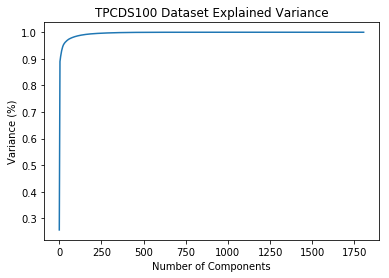

------------------------------
   Component_0  Component_1  Component_2  Component_3  Component_4  \
0    -2.820649    -2.113906    -2.343931    -1.615904    -2.051917   
1    -1.816899    -3.173899    -2.486320     2.700518    -1.801281   
2     3.570613    -2.770622    -1.778234    -4.787486    -1.197727   
3    -5.500936    -2.660140    -1.264290     2.377825     2.560968   
4     3.140048    -1.527253     2.642761     7.338900    -4.009829   

   Component_5  Component_6  Component_7  Component_8  Component_9  \
0    -0.818727    -0.004847    -0.490317     0.038525    -0.295167   
1    -0.330863     0.025888     1.985197    -0.451197     0.930810   
2    -0.537221    -0.425252     0.134725     0.830290     0.304444   
3    -0.396131     0.613302    -0.513037    -0.210905     1.203769   
4    -0.436697    -0.407539    -0.563430     0.612526     0.223827   

       ...        Component_128  Component_129  Component_130  Component_131  \
0      ...            -0.068601       0.082441 

In [16]:
class PrincipalComponentAnalysisClass:
    """
    This class handles logic related to PCA data transformations.
    https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
    """
    def __init__(self, X_df):
        """
        Cosntructor method.
        :param X_df: (Pandas) Dataframe consisting of input features, which will be subject to PCA.
        :return: None
        """
        self.__X_df = X_df
        
    def get_default_component_variances(self):
        """
        Fitting the PCA algorithm with our Data.
        :return: (Numpy array) Array of feature variances.
        """
        pca = PCA().fit(self.__X_df.values)
        return np.cumsum(pca.explained_variance_ratio_)
        
    def get_default_component_count(self, threshold=.99):
        """
        Retrieves the recommended number of component decomposition, above which very little variance 
        gain is achieved. This treshold will be set at a 0.999 variance threshold.
        :param threshold: (Float) Threshold value between 0 and 1. Stops immediately as soon the number
                                  of required components exceeds the threshold value.
        :return: (Integer) Returns the number of recommended components.
        """
        variance_ratios = self.get_default_component_variances()
        n = 0
        for val in variance_ratios:
            if val < threshold:
                n += 1
        return n
    
    def plot_variance_per_reduction(self):
        """
        This method subjects the feature matrix to a PCA decomposition. The number of components is plot
        vs the amount of retained variance.
        :return: None
        """
        variance_ratios = self.get_default_component_variances()
        
        #Plotting the Cumulative Summation of the Explained Variance
        plt.figure()
        plt.plot(variance_ratios)
        plt.xlabel('Number of Components')
        plt.ylabel('Variance (%)') #for each component
        plt.title(tpcds + ' Dataset Explained Variance')
        plt.show()
        
    def apply_PCA(self, n_components):
        """
        Applies Principle Component Analysis on the constructor passed data matrix, on a number of components.
        A new pandas data matrix is returned, with renamed 'Principal Component' headers.
        :param n_components: (Integer) Denotes number of component breakdown.
        :return: (Pandas) Dataframe consisting of new decomposed components.
        """
        pca = PCA(n_components=n_components)
        dataset = pca.fit_transform(self.__X_df.values)
        header_list = []
        for i in range(dataset.shape[1]):
            header_list.append('Component_' + str(i))
        return pd.DataFrame(data=dataset, columns=header_list)

print(X_df.head())
print(X_df.shape)

pcac = PrincipalComponentAnalysisClass(X_df=X_df)
pcac.plot_variance_per_reduction()
component_count = pcac.get_default_component_count()
X_df = pcac.apply_PCA(n_components=component_count)

print('-'*30)
print(X_df.head())
print(X_df.shape)

## LSTM Classification (Many to Many)
### Designing the network

- The first step is to define your network.
- Neural networks are defined in Keras as a sequence of layers. The container for these layers is the **Sequential class**.
- The first step is to create an instance of the Sequential class. Then you can create your layers and add them in the order that they should be connected.
- The LSTM recurrent layer comprised of memory units is called LSTM().
- A fully connected layer that often follows LSTM layers and is used for outputting a prediction is called Dense().
- The first layer in the network must define the number of inputs to expect.
- Input must be three-dimensional, comprised of samples, timesteps, and features.
    - **Samples:** These are the rows in your data.
    - **Timesteps:** These are the past observations for a feature, such as lag variables.
    - **Features:** These are columns in your data.
- Assuming your data is loaded as a NumPy array, you can convert a 2D dataset to a 3D dataset using the reshape() function in NumPy.

### Relavent Links

Network structure pointers [https://www.heatonresearch.com/2017/06/01/hidden-layers.html]. Rough heuristics to start with:

* The number of hidden neurons should be between the size of the input layer and the size of the output layer.
* The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
* The number of hidden neurons should be less than twice the size of the input layer.

--------------------------------------------------------------------------------------------

* https://machinelearningmastery.com/models-sequence-prediction-recurrent-neural-networks/
* https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/
* https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/
* https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
* https://arxiv.org/pdf/1312.6026.pdf
* https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/
* https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [17]:
# LSTM Class
class LSTM:
    """
    Long Short Term Memory Neural Net Class
    """

    def __init__(self, X, y, lag, loss_func, activation, optimizer='sgd', lstm_layers=1, dropout=.0,
                 stateful=False, y_labels=None, initializer='uniform'):
        """
        Initiating the class creates a net with the established parameters
        :param X             - (Numpy 2D Array) Training data used to train the model (Features).
        :param y             - (Numpy 2D Array) Test data used to test the model (Labels
        :param lag           - (Integer) Denotes lag step value
        :param loss_function - (String)  Denotes mode of measure fitting of model (Fitting function).
        :param activation    - (String)  Neuron activation function used to activate/trigger neurons.
        :param optimizer     - (String)  Denotes which function to us to optimize the model build (eg: Gradient Descent).
        :param lstm_layers   - (Integer) Denotes the number of LSTM layers to be included in the model build.
        :param dropout       - (Float)   Denotes amount of dropout for model. This parameter must be a value between 0 and 1.
        :param stateful      - (Boolean) Denotes whether state is used as initial state for next training batch.
        :param: y_labels     - (List) List of target label names
        :param: initializer  - (String)  String initializer which denotes starting weights.
        """
        self.__lag = lag
        self.__model = ke.models.Sequential()
        self.__y_labels = y_labels

        if dropout > 1 and dropout < 0:
            raise ValueError('Dropout parameter exceeded! Must be a value between 0 and 1.')
        
        # self.__model.add(ke.layers.Embedding(2+1, 32, input_length=X.shape[1]))
        for i in range(0, lstm_layers - 1):  # If lstm_layers == 1, this for loop logic is skipped.
            if stateful:
                if i == 0:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    batch_input_shape=(X.shape[0],
                                                                       X.shape[1],
                                                                       X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
                else:
                    self.__model.add(ke.layers.LSTM(X.shape[2],
                                                    input_shape=(X.shape[1],
                                                                 X.shape[2]),
                                                    return_sequences=True,
                                                    recurrent_dropout=dropout,
                                                    recurrent_initializer=initializer,
                                                    activation=activation,
                                                    stateful=stateful))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                return_sequences=True,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                stateful=stateful))
            self.__model.add(ke.layers.Dropout(dropout))
        if lstm_layers > 1:
            self.__model.add(ke.layers.LSTM(X.shape[2],
                                            input_shape=(X.shape[1],
                                                         X.shape[2]),
                                            stateful=stateful,
                                            recurrent_dropout=dropout,
                                            recurrent_initializer=initializer,
                                            activation=activation,
                                            return_sequences=False))
        else:
            if stateful:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                batch_input_shape=(X.shape[0],
                                                                   X.shape[1],
                                                                   X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
            else:
                self.__model.add(ke.layers.LSTM(X.shape[2],
                                                input_shape=(X.shape[1],
                                                             X.shape[2]),
                                                stateful=stateful,
                                                recurrent_dropout=dropout,
                                                recurrent_initializer=initializer,
                                                activation=activation,
                                                return_sequences=False))
        self.__model.add(ke.layers.Dropout(dropout))
        # self.__model.add(ke.layers.TimeDistributed(ke.layers.Dense(self.__lag * len(self.__y_labels), kernel_initializer=initializer)))
        self.__model.add(ke.layers.Dense(y.shape[1],
                                         kernel_initializer=initializer,
                                         activation='sigmoid'))
        self.__model.compile(loss=loss_func, optimizer=optimizer, metrics=['mse','mae'])
        print(self.__model.summary())

    def fit_model(self, X_train=None, X_test=None, y_train=None, y_test=None, epochs=50, batch_size=50, verbose=2,
                  shuffle=False, plot=False):
        """
        Fit data to model & validate. Trains a number of epochs.

        :param: X_train    - (Numpy 2D Array) Numpy matrix consisting of input training features
        :param: X_test     - (Numpy 2D Array) Numpy matrix consisting of input validation/testing features
        :param: y_train    - (Numpy 2D Array) Numpy matrix consisting of output training labels
        :param: y_test     - (Numpy 2D Array) Numpy matrix consisting of output validation/testing labels
        :param: epochs     - (Integer) Integer value denoting number of trained epochs
        :param: batch_size - (Integer) Integer value denoting LSTM training batch_size
        :param: verbose    - (Integer) Integer value denoting net verbosity (Amount of information shown to user during LSTM training)
        :param: shuffle    - (Bool) Boolean value denoting whether or not to shuffle data. This parameter must always remain 'False' for time series datasets.
        :param: plot       - (Bool) Boolean value denoting whether this function should plot out it's evaluation

        :return: None
        """
        if X_test is not None and y_test is not None:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_data=(X_test, y_test),
                                       verbose=verbose,
                                       shuffle=shuffle)
        else:
            history = self.__model.fit(x=X_train,
                                       y=y_train,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       verbose=verbose,
                                       shuffle=shuffle)

        if plot:
            plt.rcParams['figure.figsize'] = [20, 15]
            plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
            plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.show()

    def predict(self, X, batch_size):
        """
        Predicts label/s from input feature 'X'
        :param: X - Numpy matrix consisting of a single feature vector
        :param: batch_size - (Integer) Denotes prediction batch size
        :return: Numpy matrix of predicted label output
        """
        yhat = self.__model.predict(X, batch_size=batch_size)
        return yhat

    @staticmethod
    def write_results_to_disk(path, iteration, lag, test_split, batch, dropout, epoch, layer, activation, initializer,
                              stateful, rmse, accuracy, f_score, time_train):
        """
        Static method which is used for test harness utilities. This method attempts a grid search across many
        trained LSTM models, each denoted with different configurations.

        Attempted configurations:
        * Varied data test split
        * Varied batch sizes
        * Varied epoch counts

        Each configuration is denoted with a score, and used to identify the most optimal configuration.

        :param: path       - (String) String denoting result csv output.
        :param: iteration  - (Integer) Integer denoting test iteration (Unique per test configuration).
        :param: lag        - (Integer) Denotes lag time shift
        :param: test_split - (Float) Float denoting data sample sizes.
        :param: batch      - (Integer) Integer denoting LSTM batch size.
        :param: epoch      - (Integer) Integer denoting number of LSTM training iterations.
        :param: layer      - (Integer) Integer denoting number of LSTM layers
        :param: activation - (String) String denoting activation for LSTM layers.
        :param: initializer- (String) String denoting LSTM initializing weights.
        :param: stateful   - (Bool) Boolean flag which denotes whether LSTM model is trained in stateful mode or not.
        :param: dropout    - (Float) Float denoting model dropout layer.
        :param: rmse       - (Float) Float denoting experiment configuration RSME score.
        :param: accuracy   - (Float) Float denoting experiment accuracy score.
        :param: fscore     - (Float) Float denoting experiment fscore score.
        :param: time_train - (Integer) Integer denoting number of seconds taken by LSTM training iteration.

        :return: None
        """
        file_exists = os.path.isfile(path)
        with open(path, 'a+') as csvfile:
            headers = ['iteration', 'test_split', 'batch', 'epoch', 'layer', 'stateful', 'dropout', 'activation',
                       'initializer', 'rmse', 'accuracy', 'f_score', 'time_train', 'lag']
            writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=headers)
            if not file_exists:
                writer.writeheader()  # file doesn't exist yet, write a header
            writer.writerow({'iteration': iteration,
                             'test_split': test_split,
                             'batch': batch,
                             'epoch': epoch,
                             'layer': layer,
                             'stateful': stateful,
                             'dropout': dropout,
                             'activation': activation,
                             'initializer': initializer,
                             'rmse': rmse,
                             'accuracy': accuracy,
                             'f_score': f_score,
                             'time_train': time_train,
                             'lag': lag})

    @staticmethod
    def lag_multiple(X, lag):
        """
        Divides the total number of rows by the lag value, until a perfect multiple amount is retrieved.
        :param X: (Numpy) 2D array consisting of input.
        :param lag: (Integer) Denotes time shift value.
        :return: (Numpy) 2D array consisting of a perfect lag multiple rows.
        """
        n_rows = X.shape[0]
        multiple = int(n_rows/lag)
        max_new_rows = multiple * lag
        return X[0:max_new_rows, :]

### Time Step (1) - Training (CPU)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 13)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 13)] Type - <class 'numpy.ndarray'>


INFO:plaidml:Opening device "opencl_amd_tonga.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 138)            152904    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 138)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 138)               152904    
_________________________________________________________________
dropout_2 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                1807      
Total params: 307,615
Trainable params: 307,615
Non-trainable params: 0
_________________________________________________________________
None
Train on 6333 samples, validate on 6333 samples
Epoch 1/300
 - 12s - loss: 0.0895 - mean_squared_error: 0.0895 - mean_absolute_erro

Epoch 41/300
 - 3s - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0940 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0909
Epoch 42/300
 - 3s - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.0937 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0906
Epoch 43/300
 - 3s - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.0936 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0910
Epoch 44/300
 - 3s - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.0937 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0905
Epoch 45/300
 - 3s - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.0934 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0912
Epoch 46/300
 - 3s - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.0933 - val_loss: 

Epoch 87/300
 - 3s - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0889 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0909
Epoch 88/300
 - 3s - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.0886 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0905
Epoch 89/300
 - 3s - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.0886 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0907
Epoch 90/300
 - 3s - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.0885 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0902
Epoch 91/300
 - 3s - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.0884 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0903
Epoch 92/300
 - 3s - loss: 0.0202 - mean_squared_error: 0.0202 - mean_absolute_error: 0.0882 - val_loss: 

Epoch 133/300
 - 3s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.0827 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.0911
Epoch 134/300
 - 3s - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0824 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.0908
Epoch 135/300
 - 3s - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0819 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.0909
Epoch 136/300
 - 3s - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0821 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.0911
Epoch 137/300
 - 3s - loss: 0.0169 - mean_squared_error: 0.0169 - mean_absolute_error: 0.0824 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.0904
Epoch 138/300
 - 3s - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0819 - val_

Epoch 179/300
 - 3s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0779 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0910
Epoch 180/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0775 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0913
Epoch 181/300
 - 3s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0782 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.0905
Epoch 182/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0775 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.0909
Epoch 183/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0777 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0909
Epoch 184/300
 - 3s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0777 - val_

Epoch 225/300
 - 3s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0744 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.0914
Epoch 226/300
 - 3s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0746 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.0910
Epoch 227/300
 - 3s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0746 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.0914
Epoch 228/300
 - 3s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0748 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.0914
Epoch 229/300
 - 3s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0750 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.0916
Epoch 230/300
 - 3s - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0744 - val_

Epoch 271/300
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0726 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.0918
Epoch 272/300
 - 3s - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0731 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.0916
Epoch 273/300
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0726 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.0913
Epoch 274/300
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0728 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.0919
Epoch 275/300
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0727 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.0915
Epoch 276/300
 - 3s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0726 - val_

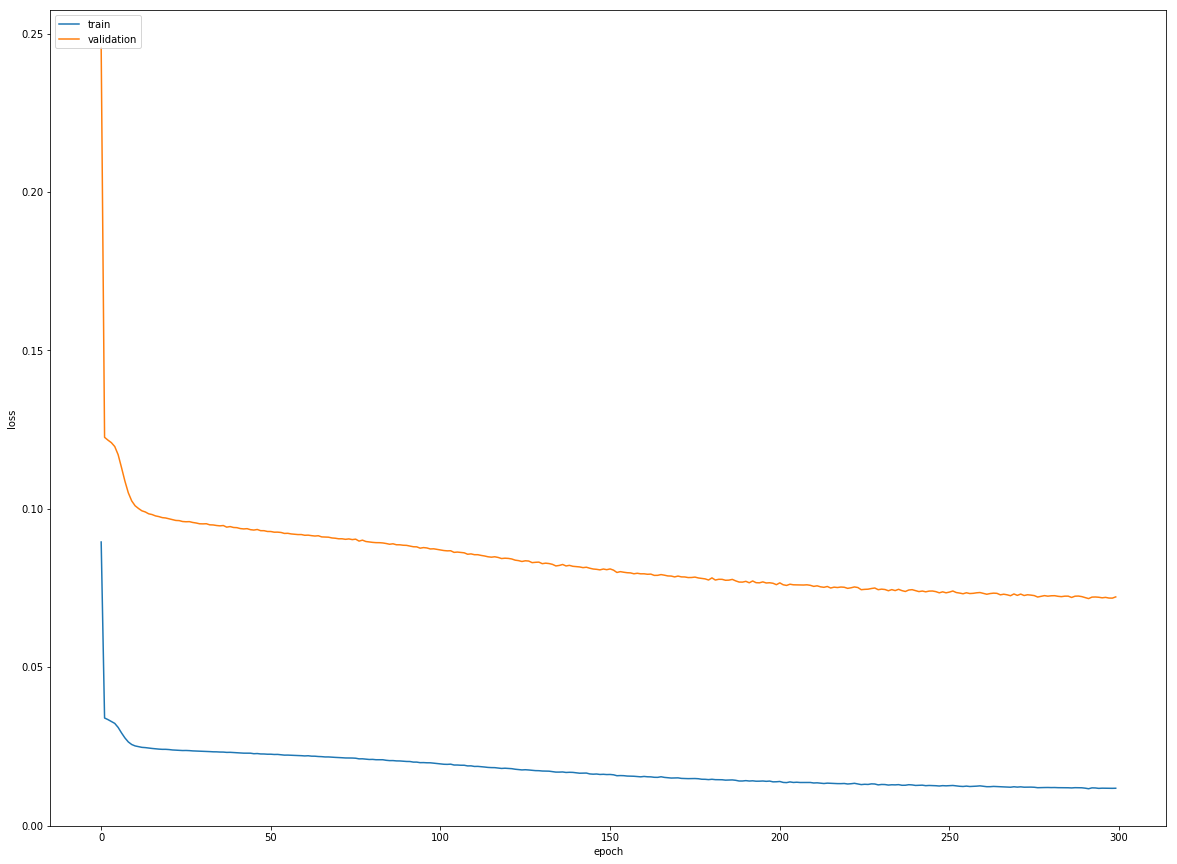

Wall time: 15min 57s


In [18]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var1' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

Day 1
Feature vectors: (904, 1, 138)
Label vectors: (904, 13)
Label: 0
Accuracy: 0.6084070796460177
F1Score: 0.2337662337662338
--------------------------
Label: 1
Accuracy: 0.6836283185840708
F1Score: 0.21428571428571427
--------------------------
Label: 2
Accuracy: 0.6272123893805309
F1Score: 0.2560706401766004
--------------------------
Label: 3
Accuracy: 0.5542035398230089
F1Score: 0.29173989455184535
--------------------------
Label: 4
Accuracy: 0.5851769911504425
F1Score: 0.24849699398797595
--------------------------
Label: 5
Accuracy: 0.6769911504424779
F1Score: 0.15606936416184972
--------------------------
Label: 6
Accuracy: 0.6769911504424779
F1Score: 0.17045454545454544
--------------------------
Label: 7
Accuracy: 0.6537610619469026
F1Score: 0.26352941176470596
--------------------------
Label: 8
Accuracy: 0.8716814159292036
F1Score: 0.7898550724637681
--------------------------
Label: 9
Accuracy: 0.922566371681416
F1Score: 0.8553719008264463
--------------------------
Lab

Label: 0
Accuracy: 0.5066371681415929
F1Score: 0.3646723646723647
--------------------------
Label: 1
Accuracy: 0.5674778761061947
F1Score: 0.3270223752151463
--------------------------
Label: 2
Accuracy: 0.4480088495575221
F1Score: 0.46516613076098606
--------------------------
Label: 3
Accuracy: 0.6227876106194691
F1Score: 0.26349892008639303
--------------------------
Label: 4
Accuracy: 0.5719026548672567
F1Score: 0.3384615384615385
--------------------------
Label: 5
Accuracy: 0.48783185840707965
F1Score: 0.3683492496589359
--------------------------
Label: 6
Accuracy: 0.4391592920353982
F1Score: 0.39999999999999997
--------------------------
Label: 7
Accuracy: 0.5873893805309734
F1Score: 0.43570347957639943
--------------------------
Label: 8
Accuracy: 0.8827433628318584
F1Score: 0.7999999999999999
--------------------------
Label: 9
Accuracy: 0.9258849557522124
F1Score: 0.8571428571428571
--------------------------
Label: 10
Accuracy: 0.875
F1Score: 0.8007054673721341
-----------

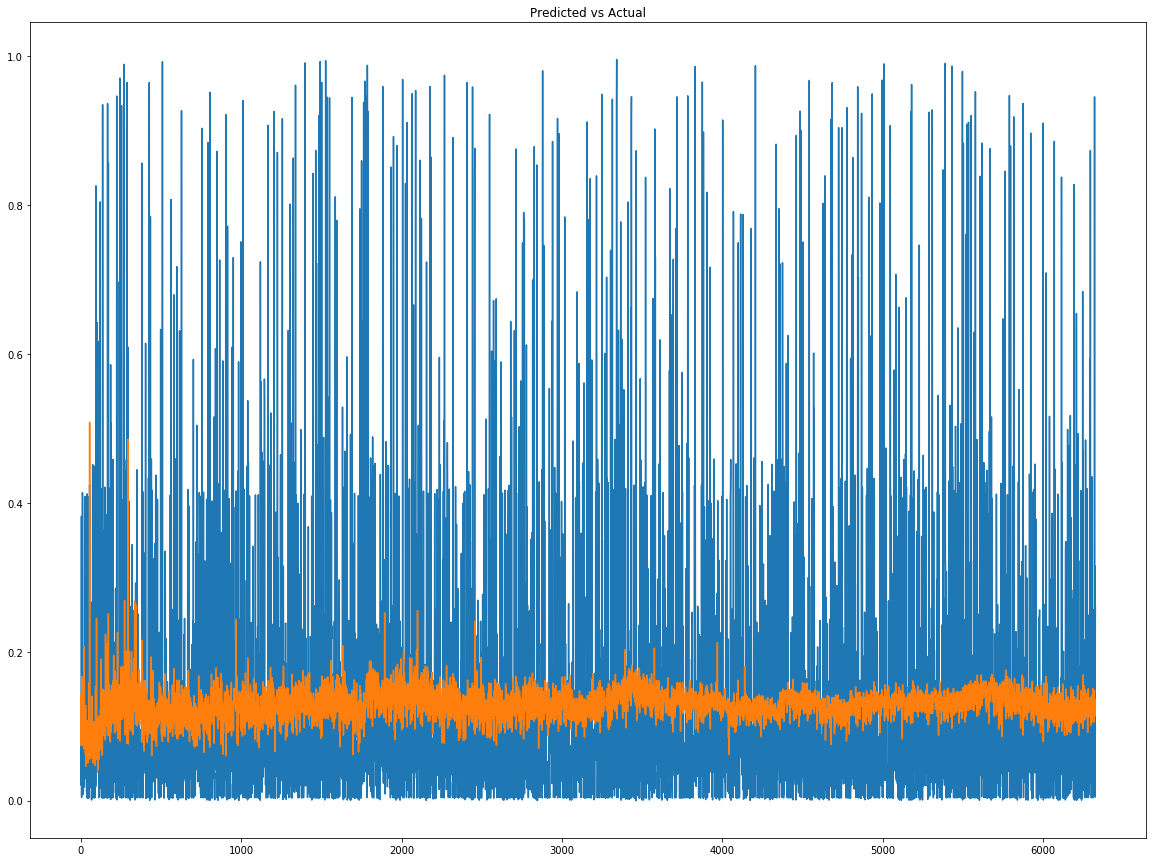

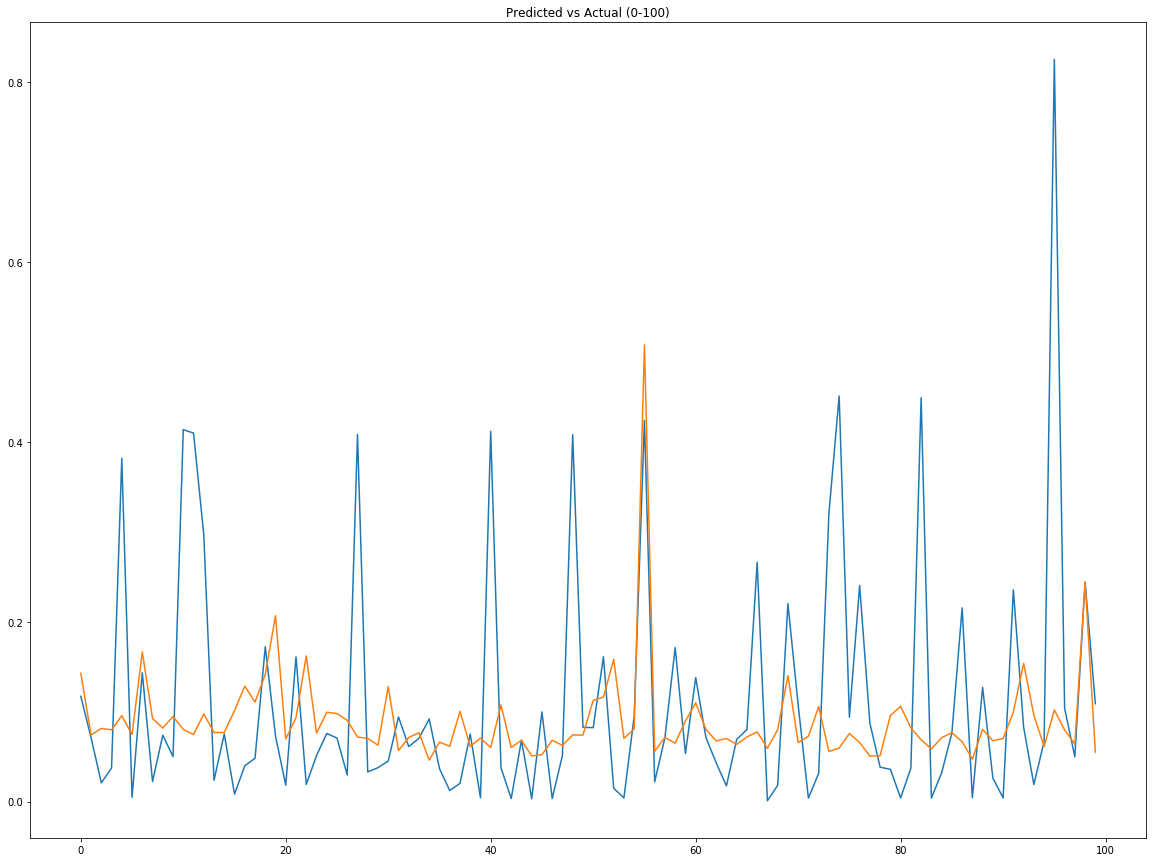

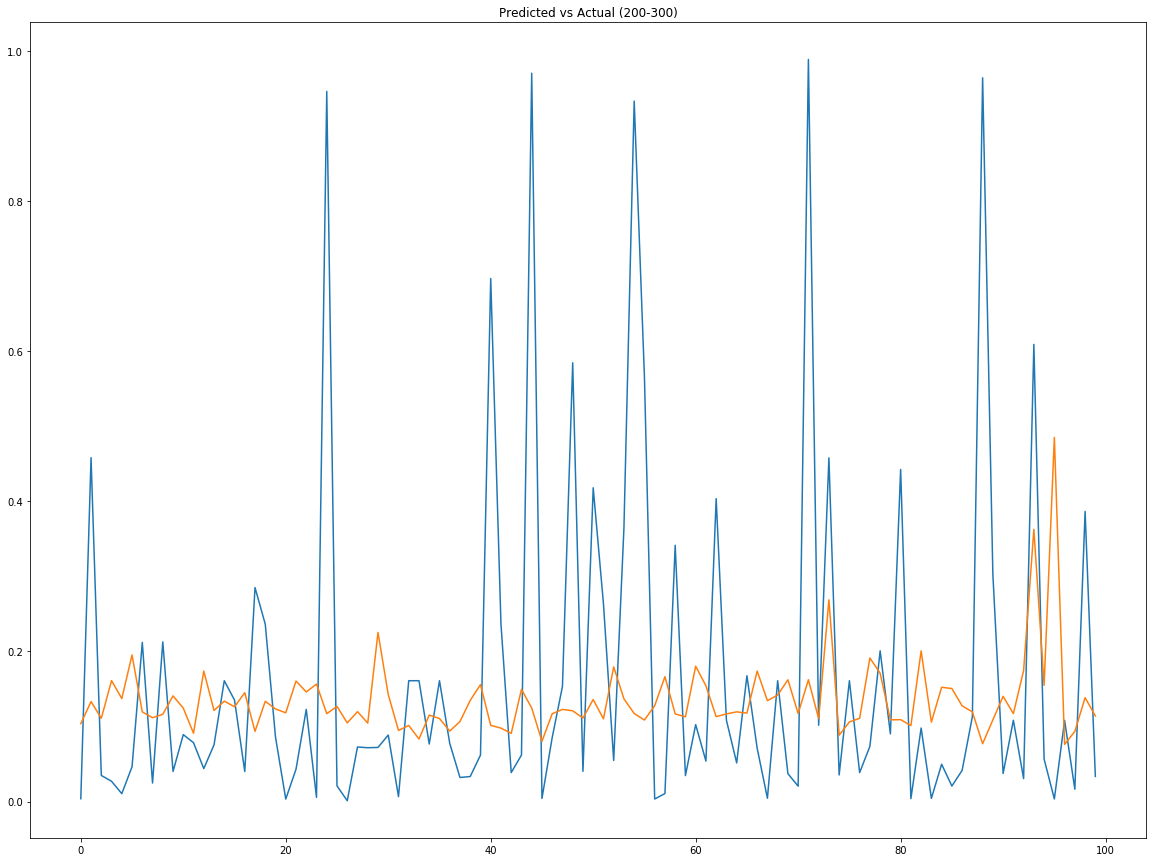

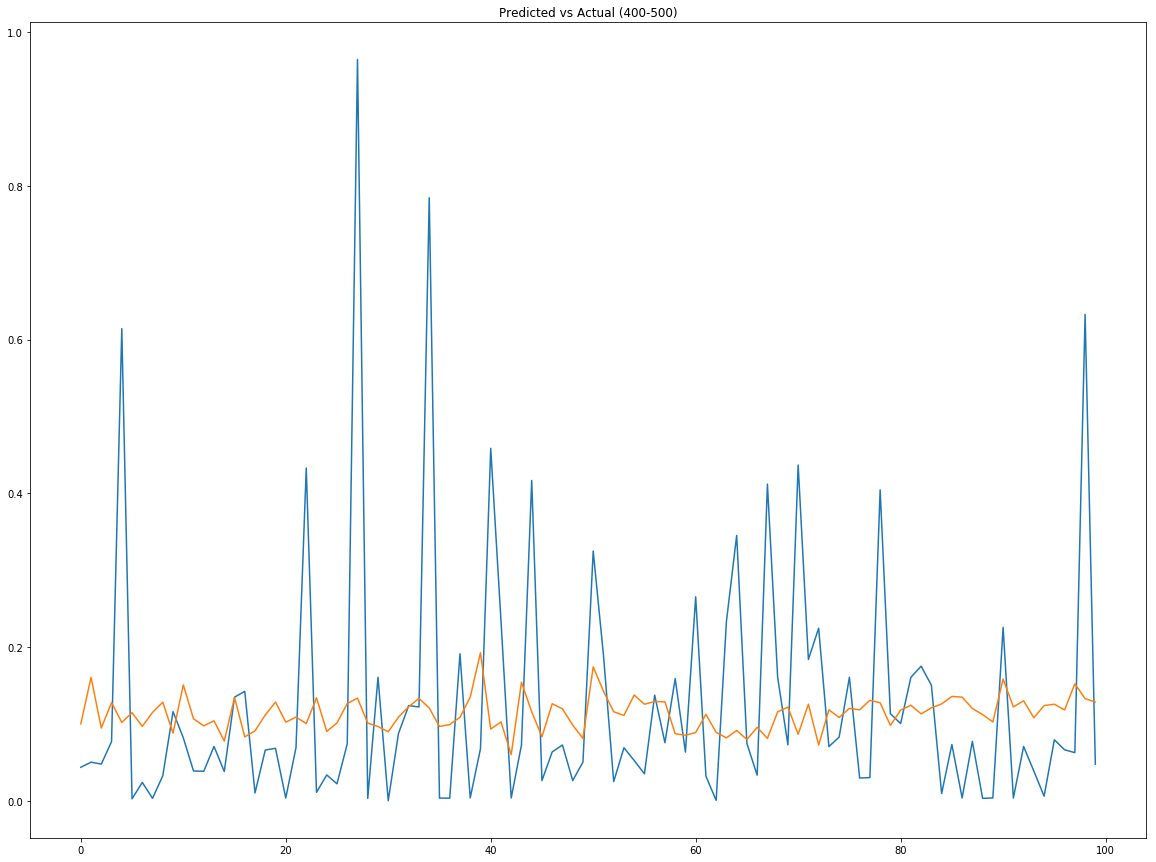

Wall time: 5min 52s


In [19]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], cpu_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)
    
#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

### Scoring per day  (CPU)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

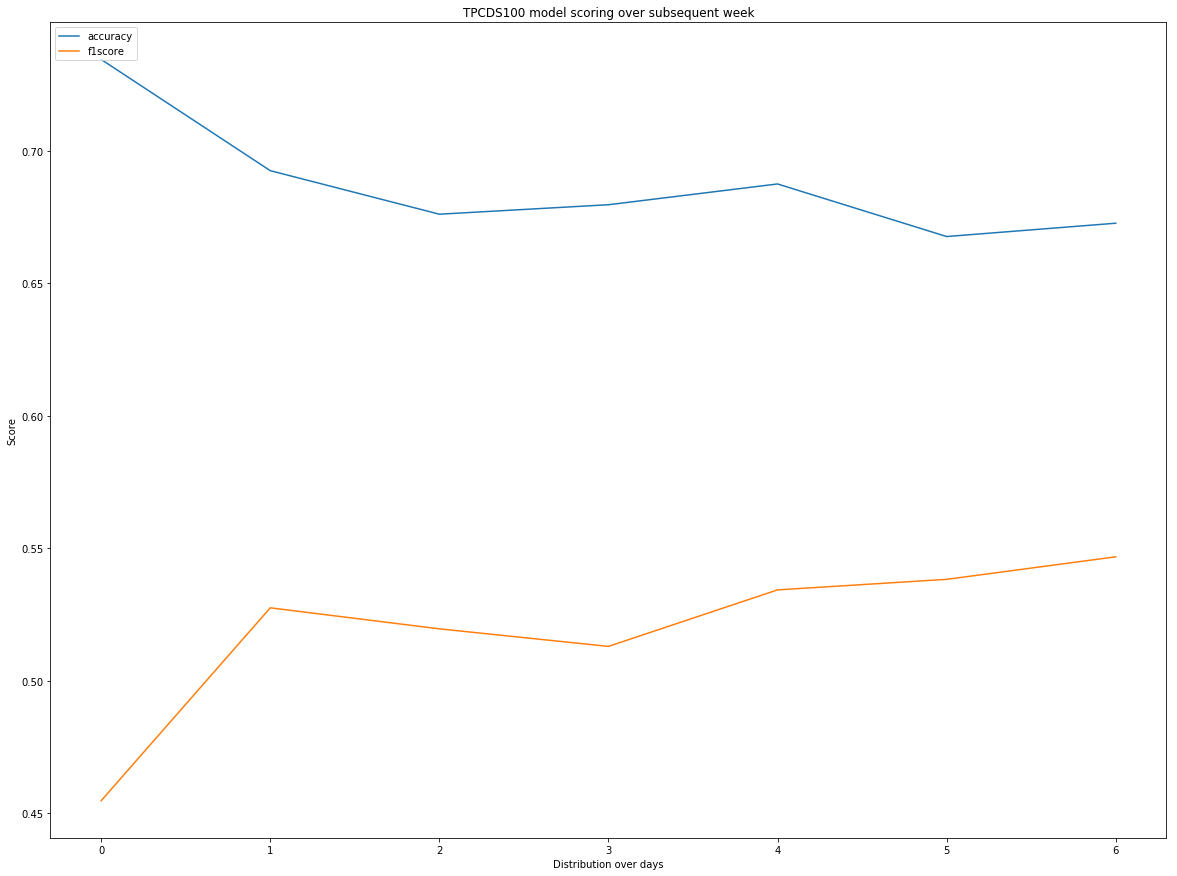

In [20]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 13)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 13)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 138)            152904    
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 138)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 138)               152904    
_________________________________________________________________
dropout_4 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                1807      
T

Epoch 40/300
 - 3s - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0847 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0858
Epoch 41/300
 - 3s - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0846 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0858
Epoch 42/300
 - 3s - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0845 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0859
Epoch 43/300
 - 3s - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0842 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0859
Epoch 44/300
 - 3s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0842 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0859
Epoch 45/300
 - 3s - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0839 - val_loss: 

Epoch 86/300
 - 3s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0777 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0876
Epoch 87/300
 - 3s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0777 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0877
Epoch 88/300
 - 3s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0774 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0876
Epoch 89/300
 - 3s - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0772 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0876
Epoch 90/300
 - 3s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0771 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0877
Epoch 91/300
 - 3s - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0772 - val_loss: 

Epoch 132/300
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0732 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0883
Epoch 133/300
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0731 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0884
Epoch 134/300
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0731 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0884
Epoch 135/300
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0731 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0883
Epoch 136/300
 - 3s - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0729 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0885
Epoch 137/300
 - 3s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0728 - val_

Epoch 178/300
 - 3s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0703 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0885
Epoch 179/300
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0701 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0885
Epoch 180/300
 - 3s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0700 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0886
Epoch 181/300
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0699 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0885
Epoch 182/300
 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0701 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0885
Epoch 183/300
 - 3s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0698 - val_

Epoch 224/300
 - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0679 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0885
Epoch 225/300
 - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0680 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0885
Epoch 226/300
 - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0679 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0885
Epoch 227/300
 - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0680 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0886
Epoch 228/300
 - 3s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0678 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0886
Epoch 229/300
 - 3s - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0678 - val_

Epoch 270/300
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0662 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0886
Epoch 271/300
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0661 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0886
Epoch 272/300
 - 3s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0664 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0885
Epoch 273/300
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0662 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0886
Epoch 274/300
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0661 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0885
Epoch 275/300
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0661 - val_

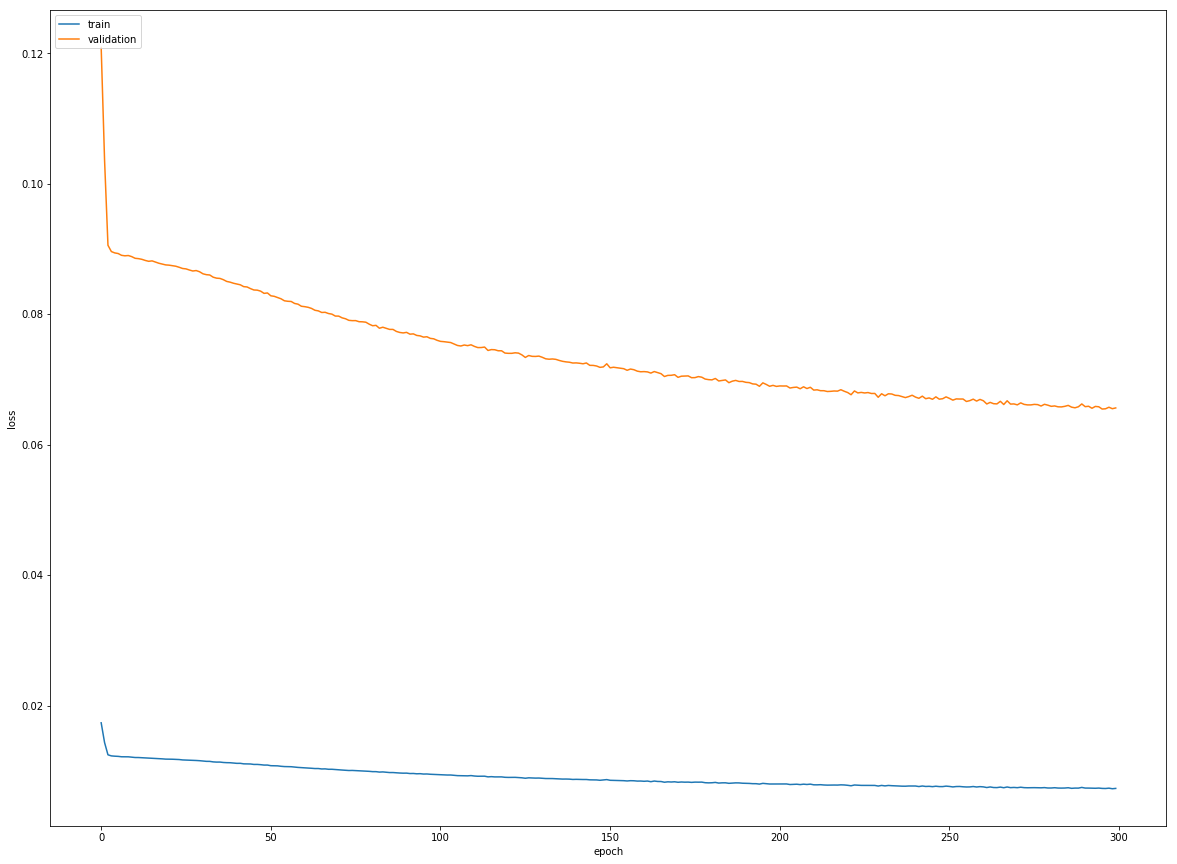

Wall time: 16min 8s


In [21]:
%%time
y_labels2 = []
for label in y_df.columns:
    if 'var2' in label:
        y_labels2.append(label)
y_df2 = y_df[y_labels2]
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df2, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

Day 1
Feature vectors: (904, 1, 138)
Label vectors: (904, 13)
Label: 0
Accuracy: 0.49336283185840707
F1Score: 0.4944812362030905
--------------------------
Label: 1
Accuracy: 0.5331858407079646
F1Score: 0.49033816425120774
--------------------------
Label: 2
Accuracy: 0.47123893805309736
F1Score: 0.4363207547169812
--------------------------
Label: 3
Accuracy: 0.4944690265486726
F1Score: 0.49278579356270813
--------------------------
Label: 4
Accuracy: 0.497787610619469
F1Score: 0.43672456575682383
--------------------------
Label: 5
Accuracy: 0.5
F1Score: 0.5086956521739132
--------------------------
Label: 6
Accuracy: 0.48451327433628316
F1Score: 0.48106904231625836
--------------------------
Label: 7
Accuracy: 0.5066371681415929
F1Score: 0.5694980694980696
--------------------------
Label: 8
Accuracy: 0.9668141592920354
F1Score: 0.9672489082969431
--------------------------
Label: 9
Accuracy: 0.9668141592920354
F1Score: 0.968421052631579
--------------------------
Label: 10
Accuracy

Label: 0
Accuracy: 0.46349557522123896
F1Score: 0.39751552795031053
--------------------------
Label: 1
Accuracy: 0.461283185840708
F1Score: 0.27637444279346207
--------------------------
Label: 2
Accuracy: 0.49668141592920356
F1Score: 0.44308445532435736
--------------------------
Label: 3
Accuracy: 0.48783185840707965
F1Score: 0.5211995863495347
--------------------------
Label: 4
Accuracy: 0.5033185840707964
F1Score: 0.3840877914951989
--------------------------
Label: 5
Accuracy: 0.5022123893805309
F1Score: 0.36974789915966383
--------------------------
Label: 6
Accuracy: 0.4811946902654867
F1Score: 0.47125140924464487
--------------------------
Label: 7
Accuracy: 0.497787610619469
F1Score: 0.4921700223713647
--------------------------
Label: 8
Accuracy: 0.959070796460177
F1Score: 0.9577142857142857
--------------------------
Label: 9
Accuracy: 0.9668141592920354
F1Score: 0.9666666666666667
--------------------------
Label: 10
Accuracy: 0.9690265486725663
F1Score: 0.969762419006479

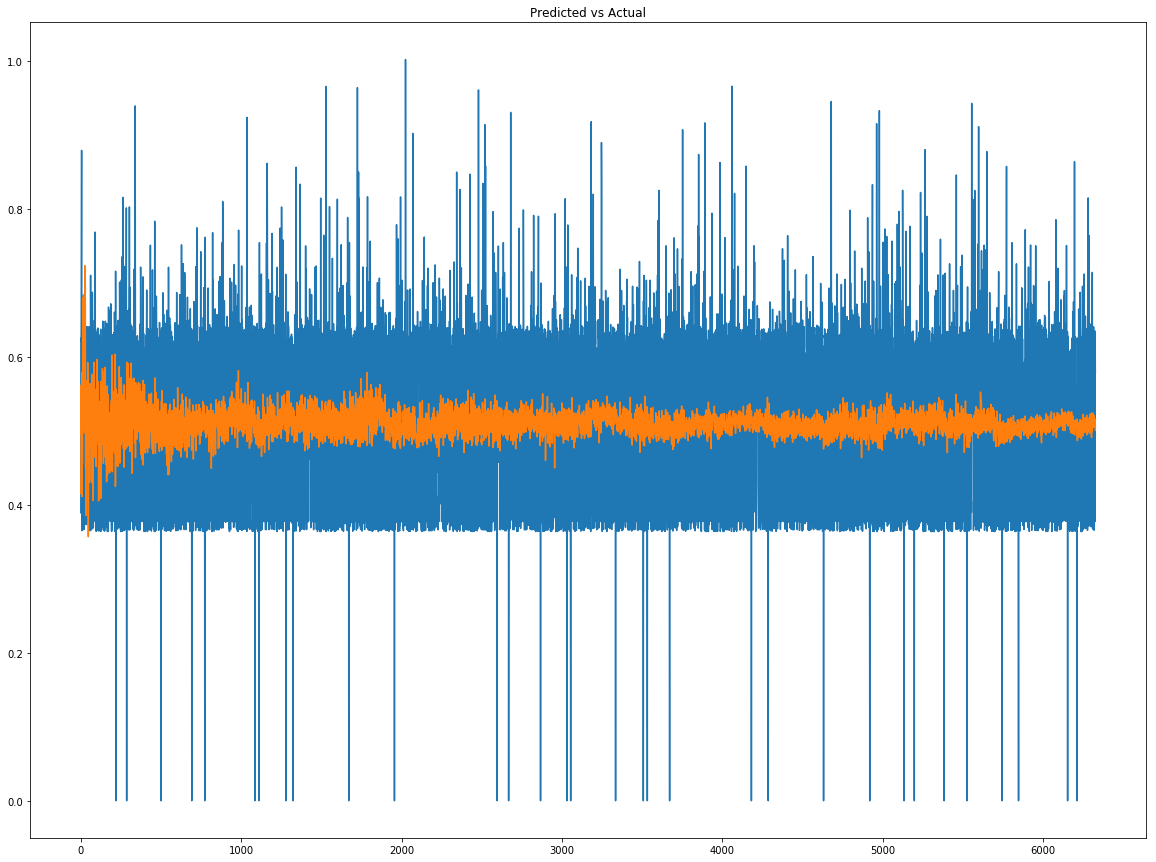

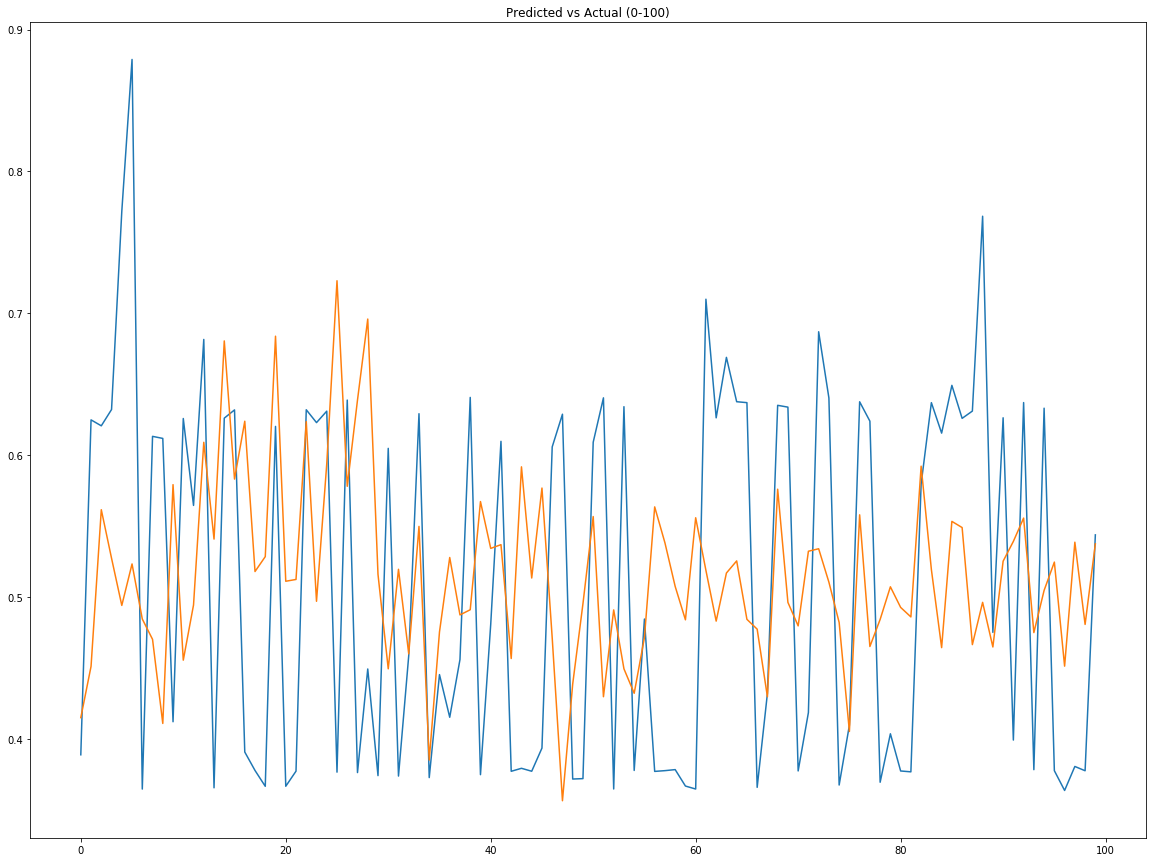

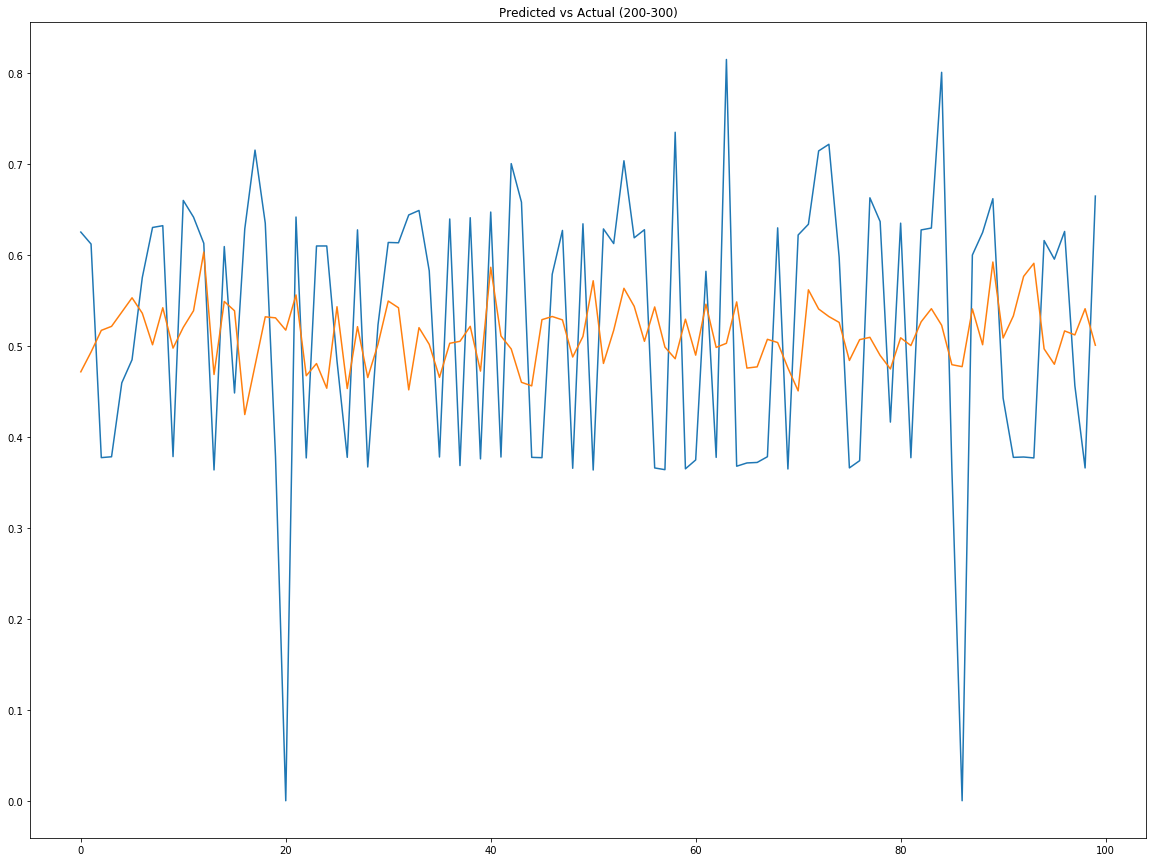

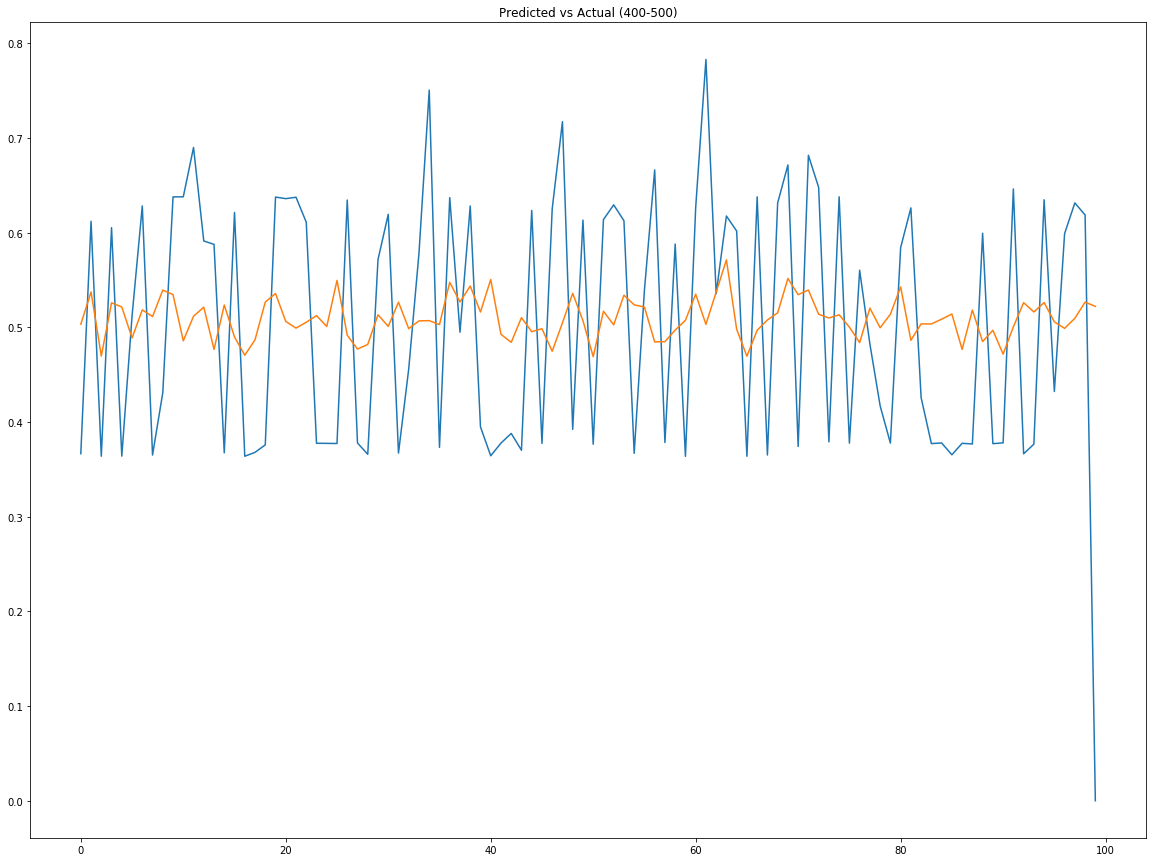

Wall time: 5min 56s


In [22]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
#NEW
y_actual, y_predicted = [],[]
#NEW
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        #NEW
        y_actual.append(y[0])
        y_predicted.append(yhat[0])
        #NEW
        
        for z in range(yhat.shape[0]):
            y[z] = BinClass.discretize_value(y[z], io_avg)
            yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(len(y_labels2)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

#NEW
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual, label='y_actual')
plt.plot(y_predicted, label='y_predicted')
plt.title('Predicted vs Actual')
plt.show()

plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[0:100], label='y_actual')
plt.plot(y_predicted[0:100], label='y_predicted')
plt.title('Predicted vs Actual (0-100)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[200:300], label='y_actual')
plt.plot(y_predicted[200:300], label='y_predicted')
plt.title('Predicted vs Actual (200-300)')
plt.show()
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(y_actual[400:500], label='y_actual')
plt.plot(y_predicted[400:500], label='y_predicted')
plt.title('Predicted vs Actual (400-500)')
plt.show()
#NEW

### Scoring per day  (IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

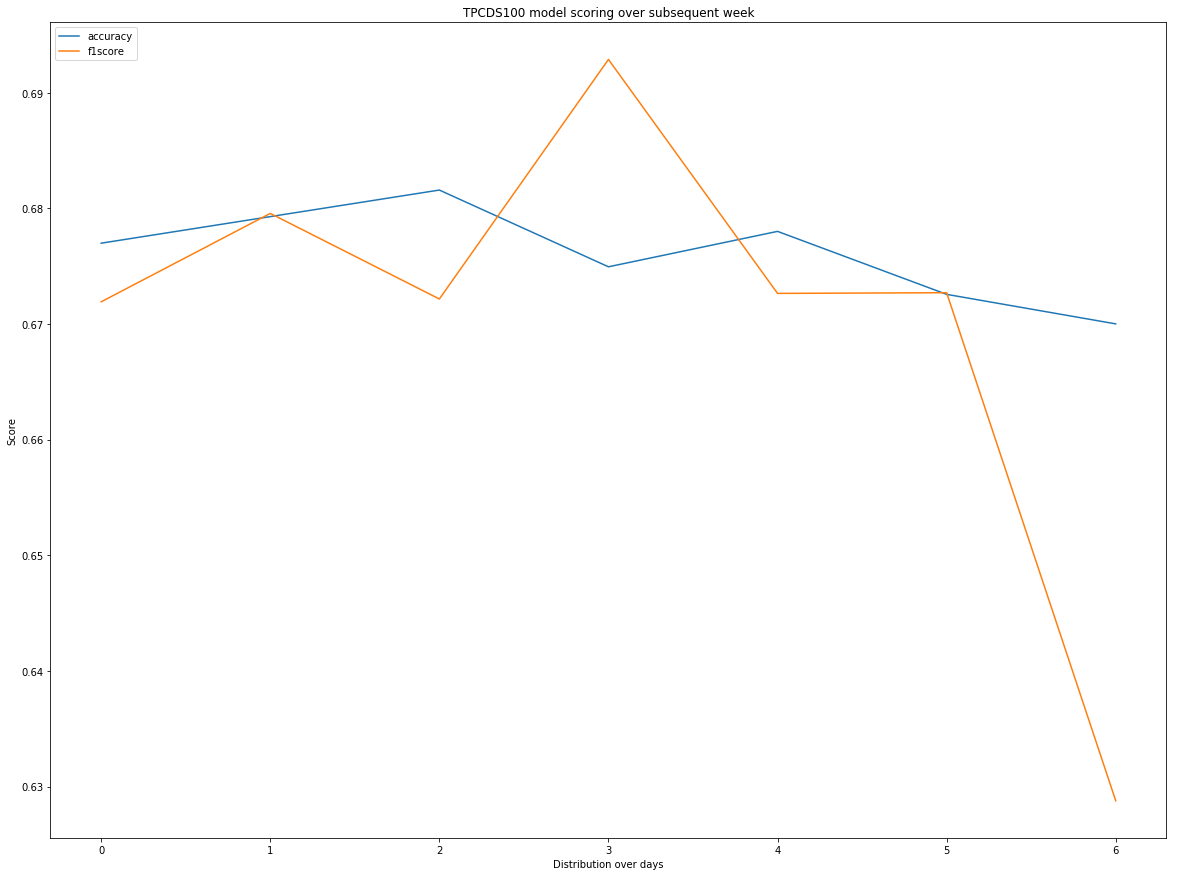

In [23]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (1) - Training (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(6333, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(6333, 1, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(6333, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 1, 138)            152904    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 138)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 138)               152904    
_________________________________________________________________
dropout_6 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 26)                3614      
T

Epoch 40/300
 - 3s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0942 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0895
Epoch 41/300
 - 3s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0942 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0895
Epoch 42/300
 - 3s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.0941 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0895
Epoch 43/300
 - 3s - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0940 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0894
Epoch 44/300
 - 3s - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0940 - val_loss: 0.0177 - val_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0894
Epoch 45/300
 - 3s - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0940 - val_loss: 

Epoch 86/300
 - 3s - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0917 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0891
Epoch 87/300
 - 3s - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0917 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0890
Epoch 88/300
 - 3s - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0918 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0891
Epoch 89/300
 - 3s - loss: 0.0168 - mean_squared_error: 0.0168 - mean_absolute_error: 0.0917 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0890
Epoch 90/300
 - 3s - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0915 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0893
Epoch 91/300
 - 3s - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.0915 - val_loss: 

Epoch 132/300
 - 3s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0895 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0890
Epoch 133/300
 - 3s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0895 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0890
Epoch 134/300
 - 3s - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0893 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0891
Epoch 135/300
 - 3s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0895 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0889
Epoch 136/300
 - 3s - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0894 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0892
Epoch 137/300
 - 3s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0895 - val_

Epoch 178/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0875 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0893
Epoch 179/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0876 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0893
Epoch 180/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0875 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0893
Epoch 181/300
 - 3s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0876 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0891
Epoch 182/300
 - 3s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0874 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0892
Epoch 183/300
 - 3s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0874 - val_

Epoch 224/300
 - 3s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0860 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0896
Epoch 225/300
 - 3s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0860 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0895
Epoch 226/300
 - 3s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0861 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0896
Epoch 227/300
 - 3s - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0860 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0896
Epoch 228/300
 - 3s - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0858 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0895
Epoch 229/300
 - 3s - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0859 - val_

Epoch 270/300
 - 3s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0849 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0896
Epoch 271/300
 - 3s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0848 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0898
Epoch 272/300
 - 3s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0847 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0899
Epoch 273/300
 - 3s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0847 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0897
Epoch 274/300
 - 3s - loss: 0.0130 - mean_squared_error: 0.0130 - mean_absolute_error: 0.0847 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0897
Epoch 275/300
 - 3s - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0849 - val_

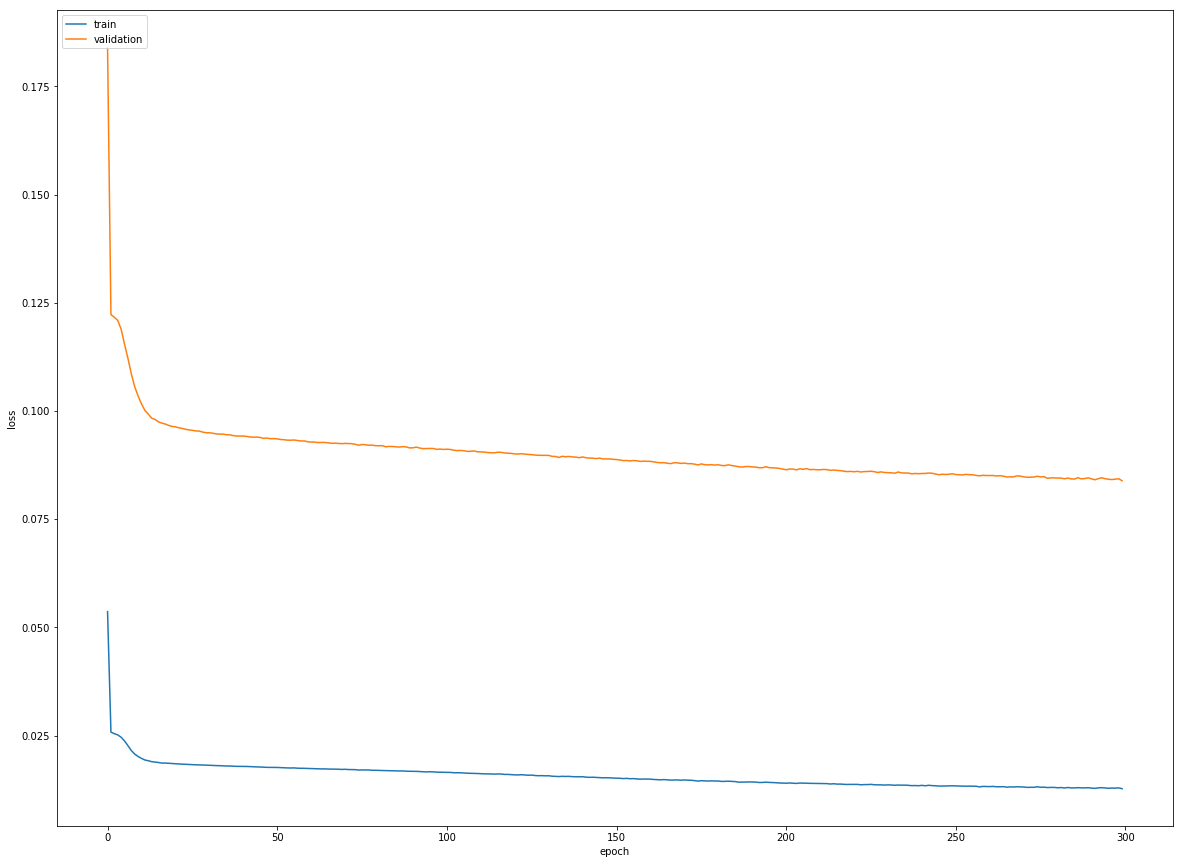

Wall time: 16min 28s


In [24]:
%%time
timestep = 1
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (1) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [25]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (904, 1, 138)
Label vectors: (904, 26)
Label: 0
Accuracy: 0.6924778761061947
F1Score: 0.19186046511627905
--------------------------
Label: 1
Accuracy: 0.4922566371681416
F1Score: 0.4730195177956372
--------------------------
Label: 2
Accuracy: 0.6216814159292036
F1Score: 0.19339622641509432
--------------------------
Label: 3
Accuracy: 0.4922566371681416
F1Score: 0.49836065573770494
--------------------------
Label: 4
Accuracy: 0.6537610619469026
F1Score: 0.21553884711779447
--------------------------
Label: 5
Accuracy: 0.4856194690265487
F1Score: 0.48957189901207465
--------------------------
Label: 6
Accuracy: 0.6559734513274337
F1Score: 0.20865139949109415
--------------------------
Label: 7
Accuracy: 0.5143805309734514
F1Score: 0.4043419267299864
--------------------------
Label: 8
Accuracy: 0.6957964601769911
F1Score: 0.14860681114551083
--------------------------
Label: 9
Accuracy: 0.4911504424778761
F1Score: 0.5
--------------------------
Label: 10
Accura

Label: 0
Accuracy: 0.6371681415929203
F1Score: 0.24074074074074076
--------------------------
Label: 1
Accuracy: 0.5221238938053098
F1Score: 0.5947467166979362
--------------------------
Label: 2
Accuracy: 0.5951327433628318
F1Score: 0.2879377431906615
--------------------------
Label: 3
Accuracy: 0.4922566371681416
F1Score: 0.5173501577287065
--------------------------
Label: 4
Accuracy: 0.5685840707964602
F1Score: 0.3133802816901408
--------------------------
Label: 5
Accuracy: 0.504424778761062
F1Score: 0.5971223021582734
--------------------------
Label: 6
Accuracy: 0.49557522123893805
F1Score: 0.3429394812680115
--------------------------
Label: 7
Accuracy: 0.49889380530973454
F1Score: 0.5226554267650159
--------------------------
Label: 8
Accuracy: 0.4657079646017699
F1Score: 0.44799999999999995
--------------------------
Label: 9
Accuracy: 0.4811946902654867
F1Score: 0.5109489051094891
--------------------------
Label: 10
Accuracy: 0.5707964601769911
F1Score: 0.36184210526315785

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

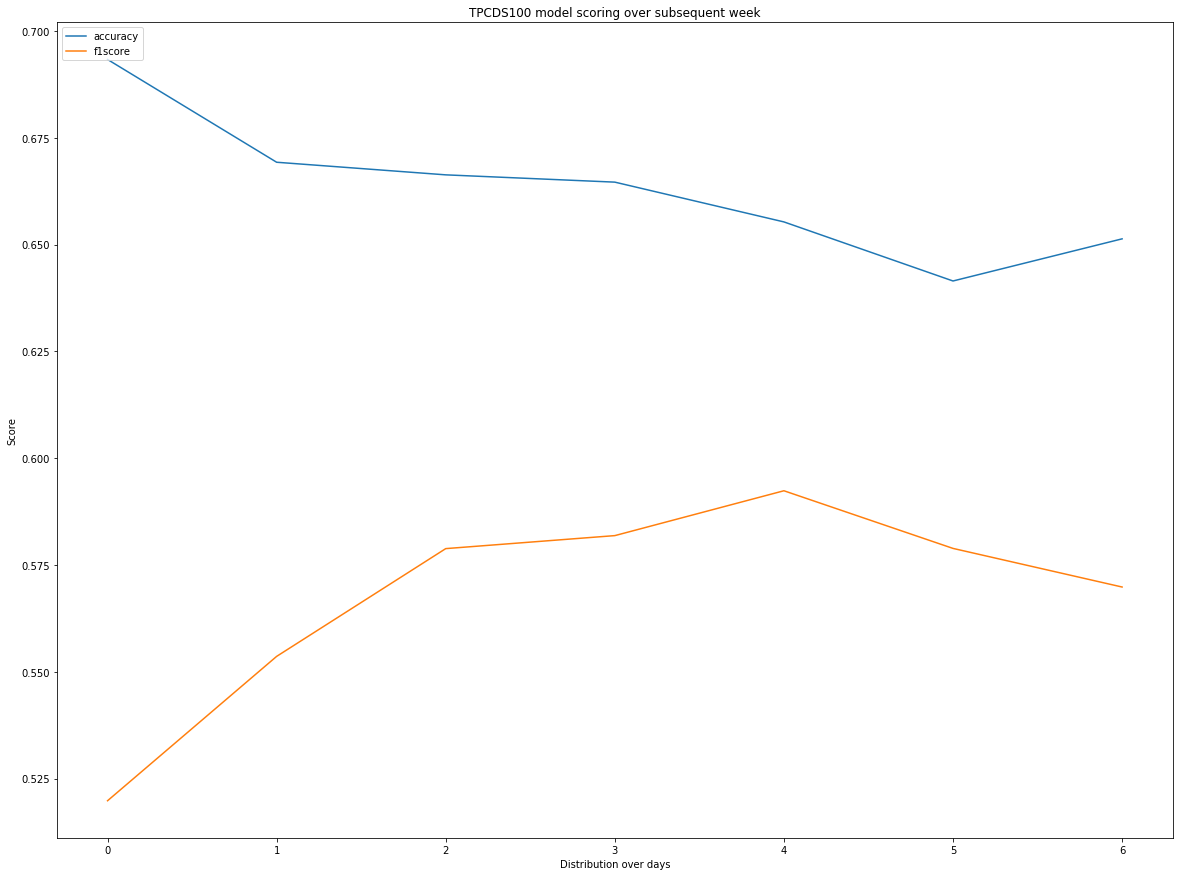

In [26]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (2) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(3166, 2, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(3166, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(3166, 2, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(3166, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 2, 138)            152904    
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 138)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 138)               152904    
_________________________________________________________________
dropout_8 (Dropout)          (None, 138)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 26)                3614      
T

Epoch 40/300
 - 2s - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1196 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1216
Epoch 41/300
 - 2s - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1194 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1219
Epoch 42/300
 - 2s - loss: 0.0242 - mean_squared_error: 0.0242 - mean_absolute_error: 0.1193 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1213
Epoch 43/300
 - 2s - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1192 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1218
Epoch 44/300
 - 2s - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1190 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1213
Epoch 45/300
 - 2s - loss: 0.0239 - mean_squared_error: 0.0239 - mean_absolute_error: 0.1187 - val_loss: 

Epoch 86/300
 - 2s - loss: 0.0181 - mean_squared_error: 0.0181 - mean_absolute_error: 0.1062 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1231
Epoch 87/300
 - 2s - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1060 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1228
Epoch 88/300
 - 2s - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.1061 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1227
Epoch 89/300
 - 2s - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.1056 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1226
Epoch 90/300
 - 2s - loss: 0.0179 - mean_squared_error: 0.0179 - mean_absolute_error: 0.1058 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1225
Epoch 91/300
 - 2s - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1051 - val_loss: 

Epoch 132/300
 - 2s - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.0989 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1230
Epoch 133/300
 - 2s - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0983 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1231
Epoch 134/300
 - 2s - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0986 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1231
Epoch 135/300
 - 2s - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0985 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1229
Epoch 136/300
 - 2s - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0983 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1226
Epoch 137/300
 - 2s - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0983 - val_

Epoch 178/300
 - 2s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0939 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1231
Epoch 179/300
 - 2s - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0943 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1226
Epoch 180/300
 - 2s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0939 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1229
Epoch 181/300
 - 2s - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0940 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1229
Epoch 182/300
 - 2s - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0934 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1230
Epoch 183/300
 - 2s - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0937 - val_

Epoch 224/300
 - 2s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0905 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1232
Epoch 225/300
 - 2s - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0901 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1229
Epoch 226/300
 - 2s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0901 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1232
Epoch 227/300
 - 2s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0905 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1228
Epoch 228/300
 - 2s - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0901 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1232
Epoch 229/300
 - 2s - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0903 - val_

Epoch 270/300
 - 2s - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0871 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1233
Epoch 271/300
 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0870 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1235
Epoch 272/300
 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0871 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1236
Epoch 273/300
 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0870 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1237
Epoch 274/300
 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0869 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1234
Epoch 275/300
 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0870 - val_

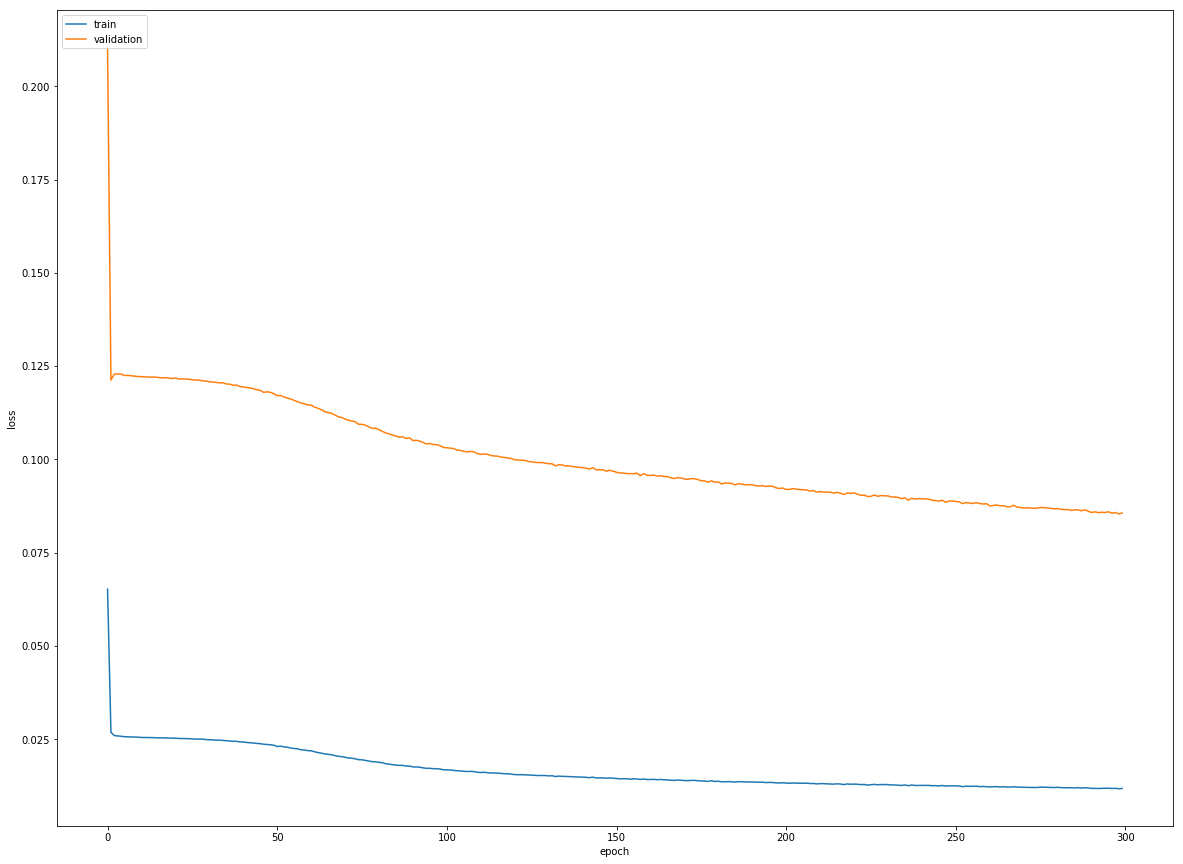

Wall time: 9min 8s


In [27]:
%%time
timestep = 2
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (2) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [28]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (452, 2, 138)
Label vectors: (452, 26)
Label: 0
Accuracy: 0.4336283185840708
F1Score: 0.36318407960199006
--------------------------
Label: 1
Accuracy: 0.5154867256637168
F1Score: 0.36151603498542273
--------------------------
Label: 2
Accuracy: 0.5597345132743363
F1Score: 0.3475409836065574
--------------------------
Label: 3
Accuracy: 0.5331858407079646
F1Score: 0.5258426966292136
--------------------------
Label: 4
Accuracy: 0.48451327433628316
F1Score: 0.3436619718309859
--------------------------
Label: 5
Accuracy: 0.4469026548672566
F1Score: 0.47698744769874474
--------------------------
Label: 6
Accuracy: 0.4424778761061947
F1Score: 0.38834951456310673
--------------------------
Label: 7
Accuracy: 0.5022123893805309
F1Score: 0.5871559633027522
--------------------------
Label: 8
Accuracy: 0.48008849557522126
F1Score: 0.42260442260442255
--------------------------
Label: 9
Accuracy: 0.4823008849557522
F1Score: 0.37765957446808507
--------------------------


Label: 0
Accuracy: 0.4446902654867257
F1Score: 0.3008356545961003
--------------------------
Label: 1
Accuracy: 0.48008849557522126
F1Score: 0.5703839122486288
--------------------------
Label: 2
Accuracy: 0.3893805309734513
F1Score: 0.4588235294117648
--------------------------
Label: 3
Accuracy: 0.5110619469026548
F1Score: 0.601801801801802
--------------------------
Label: 4
Accuracy: 0.3141592920353982
F1Score: 0.45229681978798586
--------------------------
Label: 5
Accuracy: 0.4756637168141593
F1Score: 0.381201044386423
--------------------------
Label: 6
Accuracy: 0.5376106194690266
F1Score: 0.3236245954692557
--------------------------
Label: 7
Accuracy: 0.497787610619469
F1Score: 0.5032822757111597
--------------------------
Label: 8
Accuracy: 0.4269911504424779
F1Score: 0.3759036144578313
--------------------------
Label: 9
Accuracy: 0.5265486725663717
F1Score: 0.6503267973856209
--------------------------
Label: 10
Accuracy: 0.32079646017699115
F1Score: 0.4468468468468468
---

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

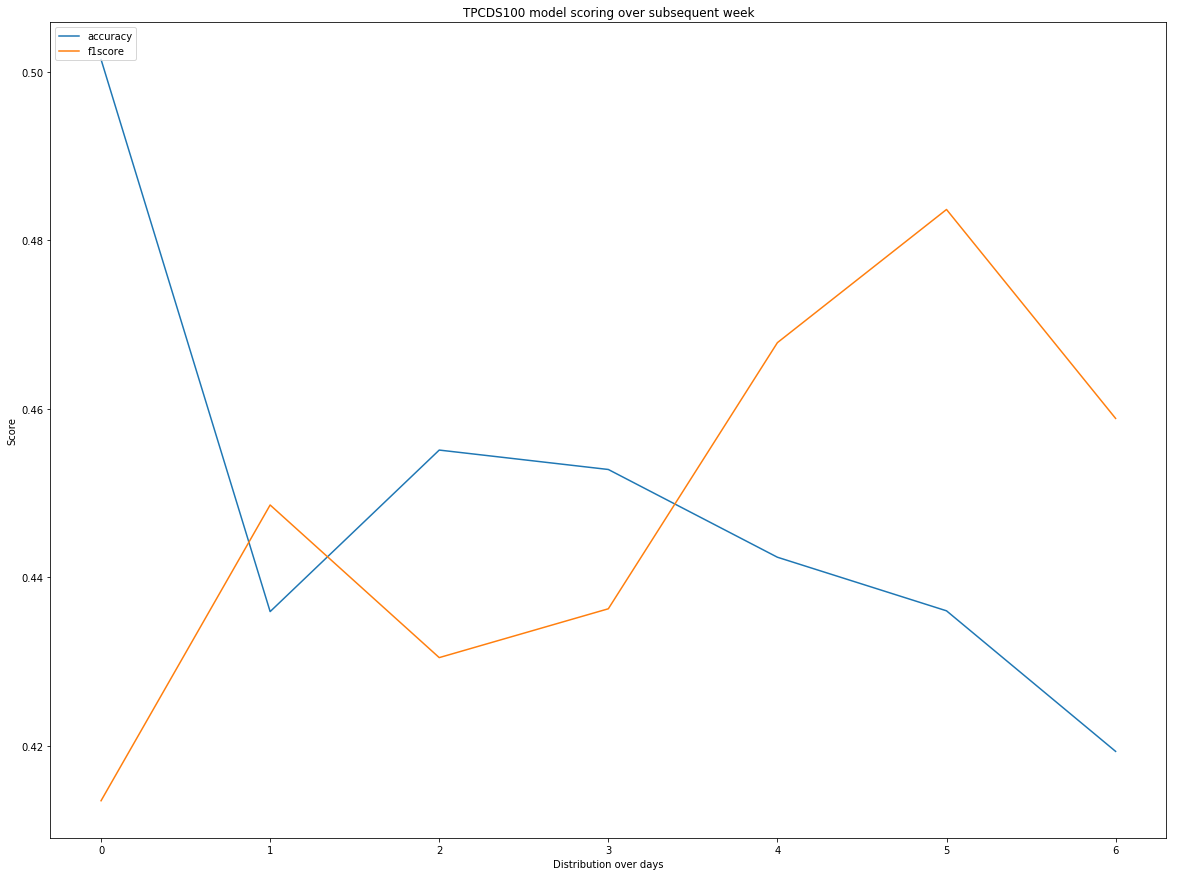

In [29]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (3) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(2111, 3, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(2111, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(2111, 3, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(2111, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 3, 138)            152904    
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 138)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 138)               152904    
_________________________________________________________________
dropout_10 (Dropout)         (None, 138)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 26)                3614      
T

Epoch 40/300
 - 1s - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1179 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1224
Epoch 41/300
 - 1s - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.1174 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1221
Epoch 42/300
 - 1s - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.1173 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1230
Epoch 43/300
 - 1s - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1163 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1231
Epoch 44/300
 - 1s - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1166 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1224
Epoch 45/300
 - 1s - loss: 0.0228 - mean_squared_error: 0.0228 - mean_absolute_error: 0.1161 - val_loss: 

Epoch 86/300
 - 1s - loss: 0.0158 - mean_squared_error: 0.0158 - mean_absolute_error: 0.1001 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1265
Epoch 87/300
 - 1s - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0999 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1260
Epoch 88/300
 - 1s - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0997 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1261
Epoch 89/300
 - 1s - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0993 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1253
Epoch 90/300
 - 1s - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0990 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1262
Epoch 91/300
 - 1s - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.0993 - val_loss: 

Epoch 132/300
 - 1s - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0919 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1248
Epoch 133/300
 - 1s - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0917 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1249
Epoch 134/300
 - 1s - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0918 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1249
Epoch 135/300
 - 1s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0915 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1250
Epoch 136/300
 - 1s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0914 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1255
Epoch 137/300
 - 1s - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0911 - val_

Epoch 178/300
 - 1s - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0862 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1256
Epoch 179/300
 - 1s - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0857 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1255
Epoch 180/300
 - 1s - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0854 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1258
Epoch 181/300
 - 1s - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0860 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1254
Epoch 182/300
 - 1s - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0855 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1256
Epoch 183/300
 - 1s - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0855 - val_

Epoch 224/300
 - 1s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0812 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1262
Epoch 225/300
 - 1s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0813 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1252
Epoch 226/300
 - 1s - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0812 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1257
Epoch 227/300
 - 1s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0809 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1251
Epoch 228/300
 - 1s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0808 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1254
Epoch 229/300
 - 1s - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0806 - val_

Epoch 270/300
 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0772 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1264
Epoch 271/300
 - 1s - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0777 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1259
Epoch 272/300
 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0771 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1255
Epoch 273/300
 - 1s - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0769 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1261
Epoch 274/300
 - 1s - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0771 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1261
Epoch 275/300
 - 1s - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0771 - val_

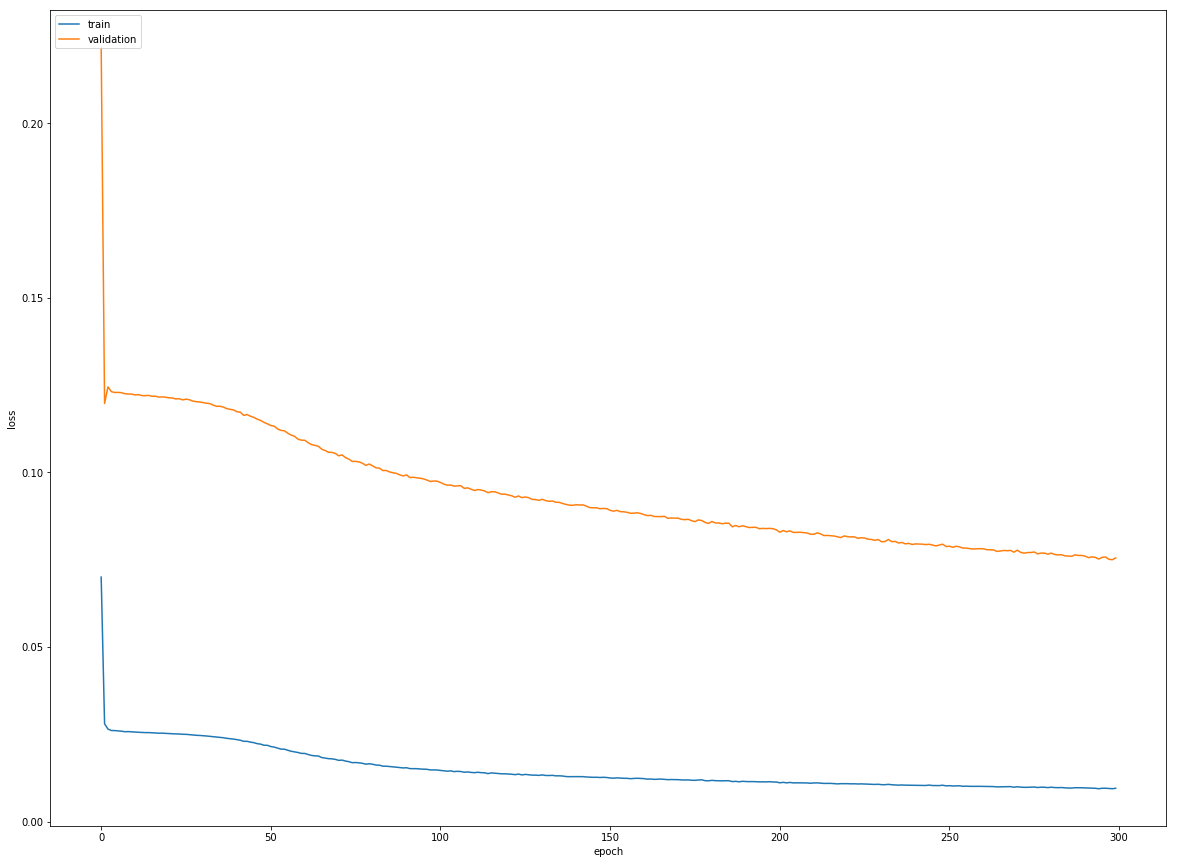

Wall time: 6min 39s


In [30]:
%%time
timestep = 3
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (3) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [31]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (301, 3, 138)
Label vectors: (301, 26)
Label: 0
Accuracy: 0.574750830564784
F1Score: 0.35353535353535354
--------------------------
Label: 1
Accuracy: 0.47840531561461797
F1Score: 0.39382239382239387
--------------------------
Label: 2
Accuracy: 0.6013289036544851
F1Score: 0.34782608695652173
--------------------------
Label: 3
Accuracy: 0.46511627906976744
F1Score: 0.4390243902439025
--------------------------
Label: 4
Accuracy: 0.48172757475083056
F1Score: 0.27777777777777773
--------------------------
Label: 5
Accuracy: 0.5348837209302325
F1Score: 0.6111111111111112
--------------------------
Label: 6
Accuracy: 0.6511627906976745
F1Score: 0.27586206896551724
--------------------------
Label: 7
Accuracy: 0.4684385382059801
F1Score: 0.4557823129251701
--------------------------
Label: 8
Accuracy: 0.5282392026578073
F1Score: 0.41803278688524587
--------------------------
Label: 9
Accuracy: 0.5448504983388704
F1Score: 0.6327077747989276
--------------------------


Label: 0
Accuracy: 0.4219269102990033
F1Score: 0.38732394366197187
--------------------------
Label: 1
Accuracy: 0.46511627906976744
F1Score: 0.5046153846153847
--------------------------
Label: 2
Accuracy: 0.43853820598006643
F1Score: 0.37638376383763833
--------------------------
Label: 3
Accuracy: 0.47840531561461797
F1Score: 0.28959276018099545
--------------------------
Label: 4
Accuracy: 0.32558139534883723
F1Score: 0.39762611275964393
--------------------------
Label: 5
Accuracy: 0.521594684385382
F1Score: 0.5068493150684932
--------------------------
Label: 6
Accuracy: 0.5149501661129569
F1Score: 0.26999999999999996
--------------------------
Label: 7
Accuracy: 0.5249169435215947
F1Score: 0.6060606060606062
--------------------------
Label: 8
Accuracy: 0.4418604651162791
F1Score: 0.3538461538461538
--------------------------
Label: 9
Accuracy: 0.5049833887043189
F1Score: 0.4501845018450185
--------------------------
Label: 10
Accuracy: 0.6877076411960132
F1Score: 0.145454545454

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

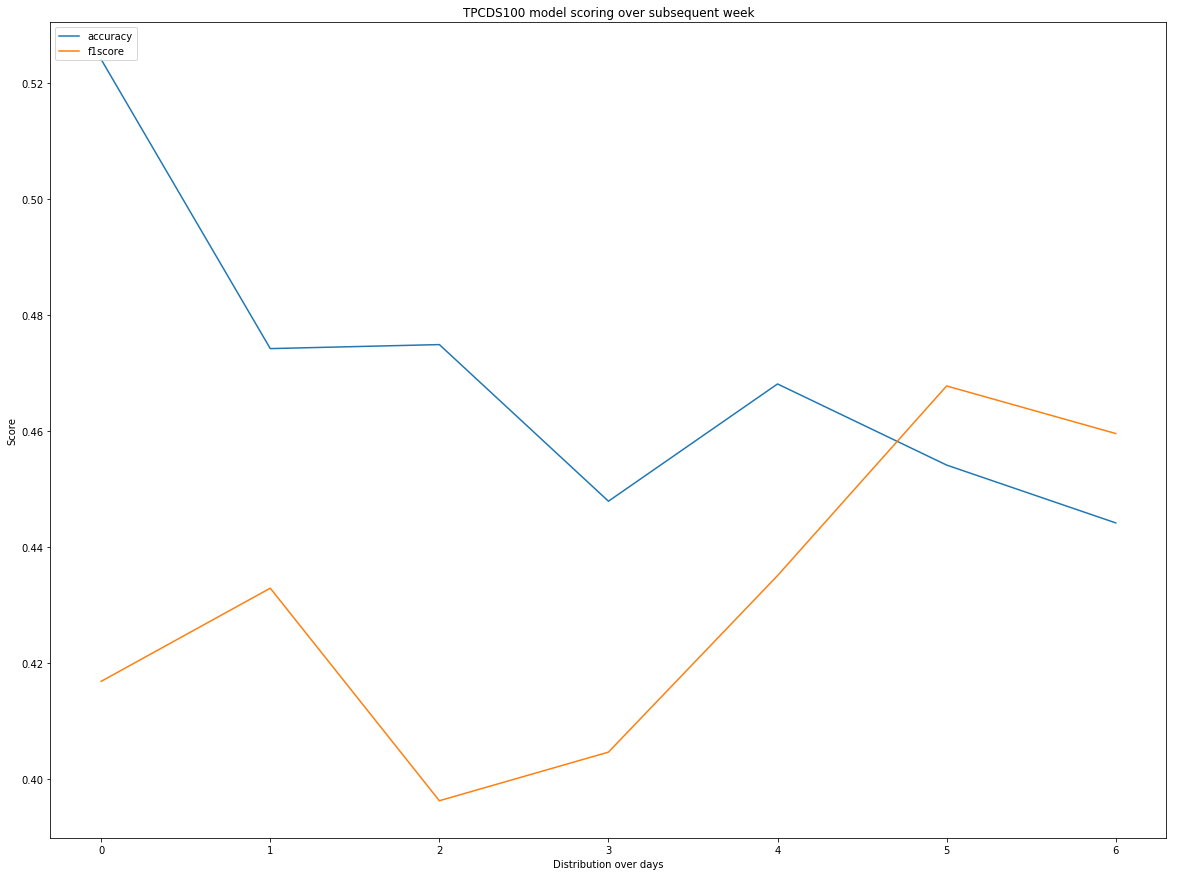

In [32]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()

### Time Step (Equal to Lag) - Training  (CPU + IO)

Timestep unrolls the LSTM model N steps during the training phase. This means that the model is influenced from prior data points during training. Training is carried out on half the trace dataset, which equates to about 7 days. The rest is left out, so as to validate the model's accuracy and f1 score.


Reshaping Training Frames
X_train shape [(527, 12, 138)] Type - <class 'numpy.ndarray'>
y_train shape [(527, 26)] Type - <class 'numpy.ndarray'>
X_validate shape [(527, 12, 138)] Type - <class 'numpy.ndarray'>
y_validate shape [(527, 26)] Type - <class 'numpy.ndarray'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 12, 138)           152904    
_________________________________________________________________
dropout_11 (Dropout)         (None, 12, 138)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 138)               152904    
_________________________________________________________________
dropout_12 (Dropout)         (None, 138)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 26)                3614      
Tot

INFO:plaidml:Analyzing Ops: 1730 of 2778 operations complete
INFO:plaidml:Analyzing Ops: 1781 of 2778 operations complete


 - 26s - loss: 0.0859 - mean_squared_error: 0.0859 - mean_absolute_error: 0.2485 - val_loss: 0.0680 - val_mean_squared_error: 0.0680 - val_mean_absolute_error: 0.2235
Epoch 2/300
 - 1s - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1782 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1204
Epoch 3/300
 - 1s - loss: 0.0310 - mean_squared_error: 0.0310 - mean_absolute_error: 0.1229 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1156
Epoch 4/300
 - 1s - loss: 0.0297 - mean_squared_error: 0.0297 - mean_absolute_error: 0.1235 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1240
Epoch 5/300
 - 1s - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1312 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1290
Epoch 6/300
 - 1s - loss: 0.0283 - mean_squared_error: 0.0283 - mean_absolute_error: 0.1309 - val_loss: 0.0261 - val_mean

Epoch 47/300
 - 1s - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1190 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1252
Epoch 48/300
 - 1s - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1189 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1258
Epoch 49/300
 - 1s - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1181 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1266
Epoch 50/300
 - 1s - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1172 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1260
Epoch 51/300
 - 1s - loss: 0.0241 - mean_squared_error: 0.0241 - mean_absolute_error: 0.1183 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1254
Epoch 52/300
 - 1s - loss: 0.0237 - mean_squared_error: 0.0237 - mean_absolute_error: 0.1166 - val_loss: 

Epoch 93/300
 - 1s - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0956 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1268
Epoch 94/300
 - 1s - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0952 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1276
Epoch 95/300
 - 1s - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0954 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1276
Epoch 96/300
 - 1s - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0941 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1265
Epoch 97/300
 - 1s - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0940 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1288
Epoch 98/300
 - 1s - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0936 - val_loss: 

Epoch 139/300
 - 1s - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0798 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1282
Epoch 140/300
 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0781 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1299
Epoch 141/300
 - 1s - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0786 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1293
Epoch 142/300
 - 1s - loss: 0.0103 - mean_squared_error: 0.0103 - mean_absolute_error: 0.0786 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1287
Epoch 143/300
 - 1s - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0778 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1289
Epoch 144/300
 - 1s - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0780 - val_

Epoch 185/300
 - 1s - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0707 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1303
Epoch 186/300
 - 1s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0697 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1290
Epoch 187/300
 - 1s - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0695 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1292
Epoch 188/300
 - 1s - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0695 - val_loss: 0.0332 - val_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.1311
Epoch 189/300
 - 1s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0689 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1293
Epoch 190/300
 - 1s - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0688 - val_

Epoch 231/300
 - 1s - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0633 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1304
Epoch 232/300
 - 1s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0633 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_mean_absolute_error: 0.1313
Epoch 233/300
 - 1s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0634 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1307
Epoch 234/300
 - 1s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0630 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1308
Epoch 235/300
 - 1s - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0638 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1311
Epoch 236/300
 - 1s - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0631 - val_

Epoch 277/300
 - 1s - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0597 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1306
Epoch 278/300
 - 1s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0596 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1311
Epoch 279/300
 - 1s - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0597 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1307
Epoch 280/300
 - 1s - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0585 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1314
Epoch 281/300
 - 1s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0590 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1308
Epoch 282/300
 - 1s - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0590 - val_

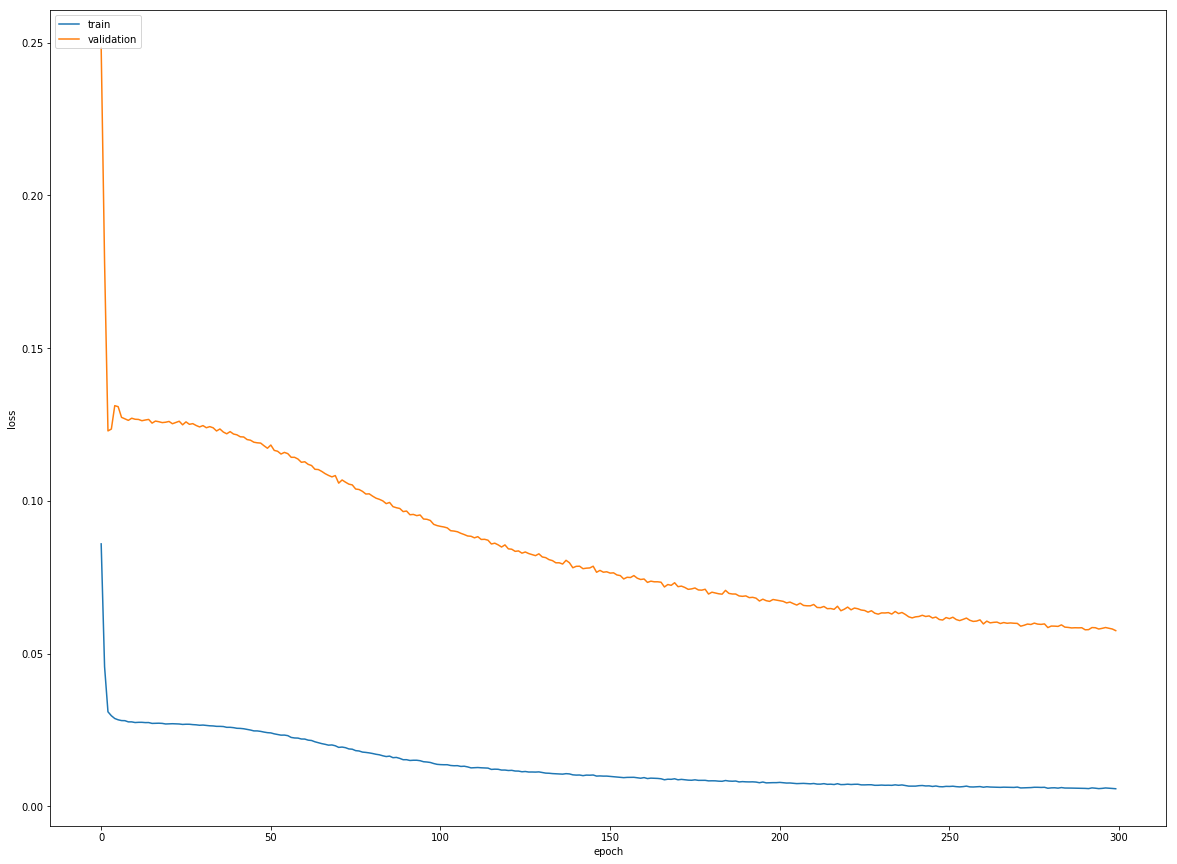

Wall time: 3min 3s


In [33]:
%%time
timestep = lag
X_train, X_validate, y_train, y_validate = train_test_split(X_df, y_df, test_size=test_split)
X_train = X_train.values
y_train = y_train.values
X_validate = X_validate.values
y_validate = y_validate.values

# Lag Multiples
X_train = LSTM.lag_multiple(X=X_train, lag=timestep)
y_train = LSTM.lag_multiple(X=y_train, lag=timestep)
X_validate = LSTM.lag_multiple(X=X_validate, lag=timestep)
y_validate = LSTM.lag_multiple(X=y_validate, lag=timestep)

# Reshape for fitting in LSTM
X_train = X_train.reshape((int(X_train.shape[0] / timestep), timestep, X_train.shape[1]))
y_train = y_train[0:int(y_train.shape[0] / timestep),:]
X_validate = X_validate.reshape((int(X_validate.shape[0] / timestep), timestep, X_validate.shape[1]))
y_validate = y_validate[0:int(y_validate.shape[0] / timestep),:]             

print('\nReshaping Training Frames')
print("X_train shape [" + str(X_train.shape) + "] Type - " + str(type(X_train)))
print("y_train shape [" + str(y_train.shape) + "] Type - " + str(type(y_train)))
print("X_validate shape [" + str(X_validate.shape) + "] Type - " + str(type(X_validate)))
print("y_validate shape [" + str(y_validate.shape) + "] Type - " + str(type(y_validate)))
   
model = LSTM(X=X_train,
             y=y_train,
             lag=lag,
             loss_func='mean_squared_error',
             activation=activation,
             optimizer='adam',
             lstm_layers=layer,
             dropout=dropout,
             stateful=state,
             y_labels=y_label,
             initializer=initializer)

model.fit_model(X_train=X_train,
                X_test=X_validate,
                y_train=y_train,
                y_test=y_validate,
                epochs=epochs,
                batch_size=batch,
                verbose=2,
                shuffle=False,
                plot=True)

### Timestep (Equal to Lag) - Evaluation  (CPU + IO)

The remaining left out data (the other half of t he dataset) is used to validate the trained model. This validation set equates to 7 days worth of data points. Below's test replicates a 7 day distribution, wherein the accuracy and f1 score of the model are evaluated at the end of each day, fit to the model in an online manner, and the process repeated for each of the following days.

In [34]:
%%time
n=7
accuracy_per_day, f1score_per_day = [], []
for i in range(0, n):
    
    print('Day ' + str(i+1))
    
    # Segregate data for specific day
    X_validate_temp = X_validate[(int(X_validate.shape[0]/n)*i):(int(X_validate.shape[0]/n)*(i+1)),:]
    y_validate_temp = y_validate[(int(y_validate.shape[0]/n)*i):(int(y_validate.shape[0]/n)*(i+1)),:]
    print('Feature vectors: ' + str(X_validate_temp.shape))
    print('Label vectors: ' + str(y_validate_temp.shape))

    y_list, yhat_list = [], []
    for j in range(0, X_validate_temp.shape[0]):
        
        X = np.array(np.array(X_validate_temp[j,:]))
        X = X.reshape((int(X.shape[0] / timestep), timestep, X.shape[1]))
        y = np.array(y_validate_temp[j, :])
        yhat = model.predict(X, batch_size=batch)
        
        y = y.reshape(1,-1)
        model.fit_model(X_train=X,
                        y_train=y,
                        epochs=2, 
                        batch_size=1,
                        verbose=0, 
                        shuffle=False,
                        plot=False) # Online Learning, Training on validation predictions. 
        
        y = y.flatten()
        yhat = yhat.flatten()
        
        for z in range(yhat.shape[0]):
            if z % 2 == 0:
                #print('CPU')
                y[z] = BinClass.discretize_value(y[z], cpu_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], cpu_avg)
            else:
                #print('IO')
                y[z] = BinClass.discretize_value(y[z], io_avg)
                yhat[z] = BinClass.discretize_value(yhat[z], io_avg)
        y_list.append(y)
        yhat_list.append(yhat)
        
#         print('Actual: ' + str(y))
#         print('Predicted: ' + str(yhat) + '\n--------------------------')
    
    y_list = np.array(y_list)
    yhat_list = np.array(yhat_list)
    
    acc_score_list, f1_score_list = [], []
    for j in range(lag * len(y_label)):
        print('Label: ' + str(j))
        acc = accuracy_score(y_list[:,j],yhat_list[:,j])
        f1 = f1_score(y_list[:,j],yhat_list[:,j], average='binary')
        print('Accuracy: ' + str(acc) + '\nF1Score: ' +  str(f1) + '\n--------------------------')
        acc_score_list.append(acc)
        f1_score_list.append(f1)
    accuracy_per_day.append(sum(acc_score_list)/len(acc_score_list))
    f1score_per_day.append(sum(f1_score_list)/len(f1_score_list))
    print('Averaged Day ' + str(j+1) + ' Accuracy: ' + str(sum(accuracy_per_day)/len(accuracy_per_day)) + '\nF1Score: ' + str(sum(f1score_per_day)/len(f1score_per_day)) + '\n--------------------------')
    print('-'*40)

Day 1
Feature vectors: (75, 12, 138)
Label vectors: (75, 26)


INFO:plaidml:Analyzing Ops: 2177 of 2775 operations complete


Label: 0
Accuracy: 0.56
F1Score: 0.1951219512195122
--------------------------
Label: 1
Accuracy: 0.5066666666666667
F1Score: 0.6021505376344085
--------------------------
Label: 2
Accuracy: 0.56
F1Score: 0.0
--------------------------
Label: 3
Accuracy: 0.44
F1Score: 0.38235294117647056
--------------------------
Label: 4
Accuracy: 0.56
F1Score: 0.15384615384615388
--------------------------
Label: 5
Accuracy: 0.56
F1Score: 0.4406779661016949
--------------------------
Label: 6
Accuracy: 0.6266666666666667
F1Score: 0.125
--------------------------
Label: 7
Accuracy: 0.52
F1Score: 0.33333333333333326
--------------------------
Label: 8
Accuracy: 0.6666666666666666
F1Score: 0.13793103448275862
--------------------------
Label: 9
Accuracy: 0.56
F1Score: 0.5074626865671642
--------------------------
Label: 10
Accuracy: 0.5466666666666666
F1Score: 0.1904761904761905
--------------------------
Label: 11
Accuracy: 0.41333333333333333
F1Score: 0.35294117647058826
--------------------------
La

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: 0
Accuracy: 0.4533333333333333
F1Score: 0.2545454545454546
--------------------------
Label: 1
Accuracy: 0.48
F1Score: 0.5979381443298969
--------------------------
Label: 2
Accuracy: 0.6133333333333333
F1Score: 0.2926829268292683
--------------------------
Label: 3
Accuracy: 0.56
F1Score: 0.5479452054794521
--------------------------
Label: 4
Accuracy: 0.49333333333333335
F1Score: 0.3666666666666667
--------------------------
Label: 5
Accuracy: 0.56
F1Score: 0.5217391304347826
--------------------------
Label: 6
Accuracy: 0.6133333333333333
F1Score: 0.25641025641025644
--------------------------
Label: 7
Accuracy: 0.5733333333333334
F1Score: 0.3333333333333333
--------------------------
Label: 8
Accuracy: 0.6
F1Score: 0.25
--------------------------
Label: 9
Accuracy: 0.44
F1Score: 0.5714285714285714
--------------------------
Label: 10
Accuracy: 0.4666666666666667
F1Score: 0.3939393939393939
--------------------------
Label: 11
Accuracy: 0.64
F1Score: 0.06896551724137931
-----

### Scoring per day  (CPU + IO)

The following plot exhibits the general effectiveness of the model over the subsequent week upon which it was tested.

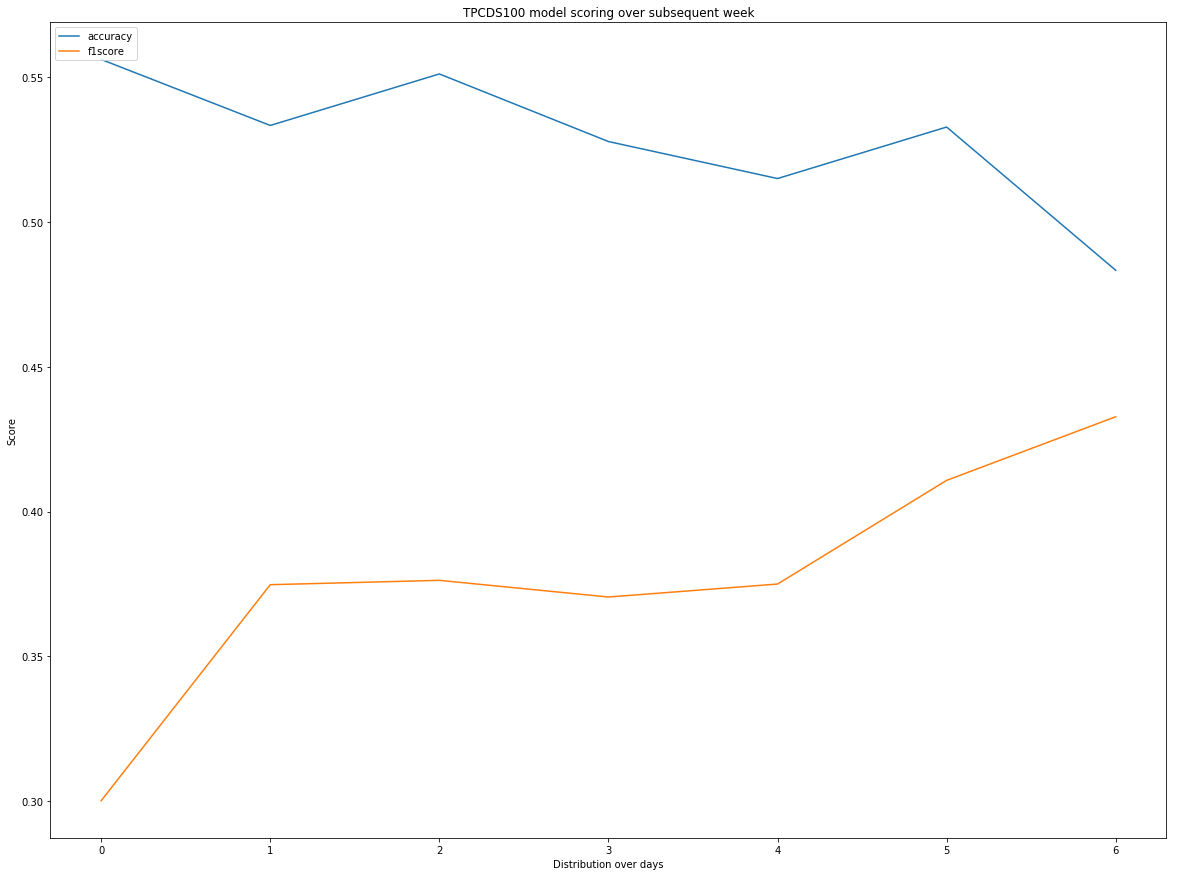

In [35]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.plot(accuracy_per_day, label='accuracy')
plt.plot(f1score_per_day, label='f1score')
plt.legend(['accuracy', 'f1score'], loc='upper left')
plt.xlabel('Distribution over days')
plt.ylabel('Score')
plt.title(tpcds + ' model scoring over subsequent week')
plt.show()